In [1]:
%pylab inline

from __future__ import (division, print_function)

import os
import sys
import copy
import fnmatch
import warnings
import collections

import numpy as np
import scipy
try:
    from scipy.stats import scoreatpercentile
except:
    scoreatpercentile = False
from scipy.interpolate import interp1d
import cPickle as pickle

# Astropy
from astropy.io import fits
from astropy    import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column
from astropy.utils.console import ProgressBar

# AstroML
from astroML.plotting import hist

# Matplotlib related
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MaxNLocator
# Matplotlib default settings
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 2.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 2.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 2.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 2.5

# Personal
import hscUtils as hUtil
import galSBP
import coaddCutoutGalfitSimple as gSimple 

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# Absolute magnitude of sun in HSC filters

# Actuall borrowed from DES filters
# Values from magsun.data in FSPS
amag_sun_des_g = 5.08
amag_sun_des_r = 4.62
amag_sun_des_i = 4.52
amag_sun_des_z = 4.52
amag_sun_des_y = 4.51

# Based on http://www.baryons.org/ezgal/filters.php
amag_sun_ukiss_y = 4.515

# Extinction correction factor for HSC 
## A\_lambda = Coeff * E(B-V) 

a_hsc_g = 3.233
a_hsc_r = 2.291 
a_hsc_i = 1.635
a_hsc_z = 1.261
a_hsc_y = 1.076

# 
SIGMA1 = 0.3173
SIGMA2 = 0.0455
SIGMA3 = 0.0027

In [3]:
def loadGalfitOutput(pklFile):     
    """
    Load a .pkl file for GALFIT model 
    Return the GalfitParser object 
    """
    if not os.path.isfile(pklFile): 
        raise Exception("XXX Can not find the .pkl file : %s") % pklFile 
    else: 
        return pickle.load(open(pklFile, 'rb'))

In [4]:
def getLuminosity(mag, redshift, extinction=None, 
                  amag_sun=None):
    """Get the absolute magnitude or luminosity."""
    distmod = hUtil.cosmoDistMod(redshift)
    absMag = (mag - distmod)
    if extinction is not None: 
        absMag -= extinction 
    if amag_sun is not None: 
        absMag = ((amag_sun - absMag) / 2.5)
    
    return absMag

In [5]:
def toColorArr(data, bottom=None, top=None):
    """ 
    Convert a data array to "color array" (between 0 and 1). 
    
    Parameters:
        bottom, top  : 
    """
    if top is not None:
        data[data >= top] = top
    if bottom is not None:
        data[data <= bottom] = bottom
        
    return ((data - np.nanmin(data)) / 
            (np.nanmax(data) - np.nanmin(data))) * 255.0

In [6]:
def pixKpc(redshift, pix=0.168, show=True, npix=1.0):
    """
    The corresponding Kpc size of a pixel 
    """
    
    pixKpc = pix * npix * hUtil.cosmoScale(redshift)
    
    if show:
        print("# %d pixel(s) = %6.3f Kpc" % (npix, pixKpc))
        
    return pixKpc

In [7]:
def get1SerSize(cat, pklDir, zStr='z', idStr='objid_dr12', pix=0.168, 
                chisqThr=4.0, nSerThr=8.0, extinctionStr='extinction_i'):
    
    galUse = np.empty(len(cat), dtype=bool)
    galUse[:] = False
    
    galRe1Ser = []
    galAr1Ser = []
    galMag1Ser = []
    galNs1Ser = []

    chi1Ser = []
    aic1Ser = []
    bic1Ser = []

    for ii, galaxy in enumerate(cat): 
                
        galId = galaxy[idStr]
        pattern1Ser = '*' + str(galId) + '*1ser.pkl'
        pattern2Ser = '*' + str(galId) + '*2ser.pkl'
        
        pkl1SerFound = findProfile(pattern1Ser, pklDir)
        pkl1SerFound = findProfile(pattern1Ser, pklDir)

        if len(pkl1SerFound) == 1:
            
            pkl1SerFile = pkl1SerFound[0]
            obj1Ser = loadGalfitOutput(pkl1SerFile)
            
            if type(obj1Ser) is not numpy.core.records.recarray:
            
                nser1Ser  = obj1Ser.component_1.n
                chisq1Ser = obj1Ser.reduced_chisq
            
                try: 
                    ai = galaxy[extinctionStr]
                except Exception:
                    ai = 0.05
            
                if (chisq1Ser <= chisqThr) and (nser1Ser < nSerThr):
                
                    scale = pixKpc(galaxy[zStr], show=False)
                    distmod = hUtil.cosmoDistMod(galaxy[zStr])
                
                    aic1, bic1, hq1 = gSimple.galfitAIC(obj1Ser)
                
                    chi1Ser.append(chisq1Ser)
                    aic1Ser.append(aic1)
                    bic1Ser.append(bic1)
        
                    galRe1Ser.append(obj1Ser.component_1.re * scale)
                    galAr1Ser.append(obj1Ser.component_1.ar)
                    galMag1Ser.append(obj1Ser.component_1.mag - ai - distmod)
                    galNs1Ser.append(obj1Ser.component_1.n)
                    
                    galUse[ii] = True
                    
    print("### Number of models : %d" % len(galRe1Ser))
    
    return galUse, galRe1Ser, galAr1Ser, galMag1Ser, galNs1Ser, chi1Ser, bic1Ser

In [8]:
def get2SerSize(cat, pklDir, zStr='z', idStr='objid_dr12', pix=0.168, 
                chisqThr=4.0, nSerThr=8.0, extinctionStr='extinction_i', 
                factor=0.95, massStr='logms_pca'):
    
    galUse = np.empty(len(cat), dtype=bool)
    galUse[:] = False
    
    galRe1Ser = []
    galAr1Ser = []
    galMag1Ser = []
    galNs1Ser = []

    chi1Ser = []
    aic1Ser = []
    bic1Ser = []
    
    galRe2SerI = []
    galAr2SerI = []
    galMag2SerI = []
    galNs2SerI = []
    
    galRe2SerO = []
    galAr2SerO = []
    galMag2SerO = []
    galNs2SerO = []
    
    innerFrac = []
    
    chi2Ser = []
    aic2Ser = []
    bic2Ser = []
    
    logmI = []
    logmO = []
    
    for ii, galaxy in enumerate(cat): 
                
        galId = galaxy[idStr]
        pattern1Ser = '*' + str(galId) + '*1ser.pkl'
        pattern2Ser = '*' + str(galId) + '*2ser.pkl'
        
        pkl1SerFound = findProfile(pattern1Ser, pklDir)
        pkl2SerFound = findProfile(pattern2Ser, pklDir)

        if (len(pkl1SerFound) == 1) and (len(pkl2SerFound) == 1):
            
            pkl1SerFile = pkl1SerFound[0]
            obj1Ser = loadGalfitOutput(pkl1SerFile)
            
            pkl2SerFile = pkl2SerFound[0]
            obj2Ser = loadGalfitOutput(pkl2SerFile)
            
            if (type(obj1Ser) is not numpy.core.records.recarray) and (
                type(obj2Ser) is not numpy.core.records.recarray):
            
                nser2A = obj1Ser.component_1.n
                nser2B = obj2Ser.component_2.n
                
                chisq1 = obj1Ser.reduced_chisq
                aic1, bic1, hq1 = gSimple.galfitAIC(obj1Ser)
                
                chisq2 = obj1Ser.reduced_chisq
                aic2, bic2, hq2 = gSimple.galfitAIC(obj2Ser)
            
                try: 
                    ai = galaxy[extinctionStr]
                except Exception:
                    ai = 0.05
            
                logmT = galaxy[massStr]

                if (logmT >= 11.2) and (bic2 < bic1) and (aic2 < aic1) and (
                    nser2A <= nSerThr) and (nser2B <= nSerThr):
                
                    scale = pixKpc(galaxy[zStr], show=False)
                    distmod = hUtil.cosmoDistMod(galaxy[zStr])
                
                    chi1Ser.append(chisq1)
                    aic1Ser.append(aic1)
                    bic1Ser.append(bic1)
        
                    galRe1Ser.append(obj1Ser.component_1.re * np.sqrt(obj1Ser.component_1.ar) * scale)
                    galAr1Ser.append(obj1Ser.component_1.ar)
                    galMag1Ser.append(obj1Ser.component_1.mag - ai - distmod)
                    galNs1Ser.append(obj1Ser.component_1.n)
                    
                    """ 2 Sersic part """
                    chi2Ser.append(chisq2)
                    aic2Ser.append(aic2)
                    bic2Ser.append(bic2)
                    
                    if (obj2Ser.component_1.re <= obj2Ser.component_2.re): 
                        compInner = obj2Ser.component_1
                        compOuter = obj2Ser.component_2
                    else: 
                        compInner = obj2Ser.component_2 
                        compOuter = obj2Ser.component_1

                    galRe2SerI.append(compInner.re * scale * np.sqrt(compInner.ar))
                    galAr2SerI.append(compInner.ar)
                    galMag2SerI.append(compInner.mag)
                    galNs2SerI.append(compInner.n)

                    galRe2SerO.append(compOuter.re * scale * np.sqrt(compOuter.ar))
                    galAr2SerO.append(compOuter.ar)
                    galMag2SerO.append(compOuter.mag)
                    galNs2SerO.append(compOuter.n)  
                                        
                    fluxI = 10.0 ** ((27.0 - compInner.mag) / 2.5)
                    fluxO = 10.0 ** ((27.0 - compOuter.mag) / 2.5)
                    innerFrac.append(fluxI / (fluxI + fluxO))
                    
                    logmI.append(logmT + np.log10(fluxI / (fluxI + fluxO)))
                    logmO.append(logmT + np.log10(fluxO / (fluxI + fluxO)))

                    galUse[ii] = True
                    
    print("### Number of models : %d" % len(galRe1Ser))
    
    return galRe2SerI, galRe2SerO, logmI, logmO

# Results by 2016-01-11

* Three major datasets: 
    
    1. redBCG - `/Users/songhuang/work/hscs/gama_massive/galfit/redbcg`: **xx** galaxies (vetted)
        - `redbcg_mass_use_dom.fits`
    2. redMem - `/Users/songhuang/work/hscs/gama_massive/galfit/redmem`: **xxx** galaxies (not vetted)
        - `redmapper_mem_hscmatch_mass_sbpsum_modA_muI1.fits`
    3. gama - `/Users/songhuang/work/hscs/gama_massive/galfit/gama`: **xxx** galaxies (not vetted)
        - `gama_massive_160107_sbpsum_modA_muI1.fits`
        - Will be separated into different samples: `GAMA1`, `GAMA2`, `GAMA3`

In [9]:
newDir = '/Users/songhuang/work/hscs/gama_massive/galfit/'

try:
    bcgTab
except NameError:
    pass
else:
    del bcgTab
    
try:
    memTab
except NameError:
    pass
else:
    del memTab    
    
try:
    gamaTab
except NameError:
    pass
else:
    del gamaTab
    
# Folder for 3 datasets
bcgDir = os.path.join(newDir, 'redbcg')
memDir = os.path.join(newDir, 'redmem')
gama1Dir = os.path.join(newDir, 'gama1')
gama2Dir = os.path.join(newDir, 'gama2')
gama3Dir = os.path.join(newDir, 'gama3')

# Two summary catalogs
#bcgCat = os.path.join(bcgDir, 'redmapper_bcg_hscmatch_mass_use_sbpsum_modA_muI1.fits')
bcgCat = os.path.join(newDir, 'redbcg_mass_use_dom.fits')
memCat = os.path.join(newDir, 'redmapper_mem_hscmatch_mass_sbpsum_modA_muI1.fits')
gama1Cat = os.path.join(newDir, 'gama1_mass_sbpsum_modA_muI1.fits')
gama2Cat = os.path.join(newDir, 'gama2_mass_sbpsum_modA_muI1.fits')
gama3Cat = os.path.join(newDir, 'gama3_mass_sbpsum_modA_muI1.fits')

if not os.path.isfile(bcgCat):
    raise Exception("## Can not find catalog for BCGs : %s" % bcgCat)
else: 
    bcgTab = Table.read(bcgCat, format='fits')

if not os.path.isfile(memCat):
    raise Exception("## Can not find catalog for cluster members : %s" % memCat)
else: 
    memTab = Table.read(memCat, format='fits')
    
if not os.path.isfile(gama1Cat):
    raise Exception("## Can not find catalog for GAMA galaxies : %s" % gama1Cat)
else: 
    gama1Tab = Table.read(gama1Cat, format='fits')

if not os.path.isfile(gama2Cat):
    raise Exception("## Can not find catalog for GAMA galaxies : %s" % gama2Cat)
else: 
    gama2Tab = Table.read(gama2Cat, format='fits')

if not os.path.isfile(gama3Cat):
    raise Exception("## Can not find catalog for GAMA galaxies : %s" % gama3Cat)
else: 
    gama3Tab = Table.read(gama3Cat, format='fits')

In [10]:
print("## Deal with %i galaxies in BCG sample" % len(bcgTab))
print("## Deal with %i galaxies in Cluster member sample" % len(memTab))
print("## Deal with %i galaxies in GAMA1 sample" % len(gama1Tab))
print("## Deal with %i galaxies in GAMA2 sample" % len(gama2Tab))
print("## Deal with %i galaxies in GAMA3 sample" % len(gama3Tab))

## Deal with 219 galaxies in BCG sample
## Deal with 1670 galaxies in Cluster member sample
## Deal with 3747 galaxies in GAMA1 sample
## Deal with 1700 galaxies in GAMA2 sample
## Deal with 2718 galaxies in GAMA3 sample


In [28]:
mc = np.asarray([10.8, 11.2, 11.4, 11.6, 11.8])
rc = np.asarray([0.49, 0.774, 0.877, 1.101, 1.264])

ms = np.asarray([10.6, 10.8, 11.0, 11.2, 11.4, 11.6])
rs = np.asarray([0.389, 0.485, 0.616, 0.759, 0.891, 1.112])

# BCGs

## Estimate the luminosity, mass-to-light ratio, and stellar mass 
    - Consider the the K-correction 
    - Consider the differen mass models

In [11]:
### There are something wrong with the Kcorrection in the catalog....Update the Kcorrection value!!
"""
Using Kcorrect = absmag_cmodel - ABSMAG_ISEDFIT
"""
# Get absolute magnitude
amagG_bcg = getLuminosity(bcgTab['gmag_cmodel'], bcgTab['Z'], extinction=bcgTab['a_g'])
amagR_bcg = getLuminosity(bcgTab['rmag_cmodel'], bcgTab['Z'], extinction=bcgTab['a_r'])
amagI_bcg = getLuminosity(bcgTab['imag_cmodel'], bcgTab['Z'], extinction=bcgTab['a_i'])
amagZ_bcg = getLuminosity(bcgTab['zmag_cmodel'], bcgTab['Z'], extinction=bcgTab['a_z'])
amagY_bcg = getLuminosity(bcgTab['ymag_cmodel'], bcgTab['Z'], extinction=bcgTab['a_y'])

# Model A
bcgTab['KCORRECT_G'] = (amagG_bcg - bcgTab['ABSMAG_G'])
bcgTab['KCORRECT_R'] = (amagR_bcg - bcgTab['ABSMAG_R'])
bcgTab['KCORRECT_I'] = (amagI_bcg - bcgTab['ABSMAG_I'])
bcgTab['KCORRECT_Z'] = (amagZ_bcg - bcgTab['ABSMAG_Z'])
bcgTab['KCORRECT_Y'] = (amagY_bcg - bcgTab['ABSMAG_Y'])

# Model B
bcgTab['KCORRECT_b_G'] = (amagG_bcg - bcgTab['ABSMAG_b_G'])
bcgTab['KCORRECT_b_R'] = (amagR_bcg - bcgTab['ABSMAG_b_R'])
bcgTab['KCORRECT_b_I'] = (amagI_bcg - bcgTab['ABSMAG_b_I'])
bcgTab['KCORRECT_b_Z'] = (amagZ_bcg - bcgTab['ABSMAG_b_Z'])
bcgTab['KCORRECT_b_Y'] = (amagY_bcg - bcgTab['ABSMAG_b_Y'])

# Model C
bcgTab['KCORRECT_c_G'] = (amagG_bcg - bcgTab['ABSMAG_c_G'])
bcgTab['KCORRECT_c_R'] = (amagR_bcg - bcgTab['ABSMAG_c_R'])
bcgTab['KCORRECT_c_I'] = (amagI_bcg - bcgTab['ABSMAG_c_I'])
bcgTab['KCORRECT_c_Z'] = (amagZ_bcg - bcgTab['ABSMAG_c_Z'])
bcgTab['KCORRECT_c_Y'] = (amagY_bcg - bcgTab['ABSMAG_c_Y'])

In [12]:
### There are something wrong with the Kcorrection in the catalog....Update the Kcorrection value!!
"""
Using Kcorrect = absmag_cmodel - ABSMAG_ISEDFIT
"""
# Get absolute magnitude
amagG_mem = getLuminosity(memTab['gmag_cmodel'], memTab['Z'], extinction=memTab['a_g'])
amagR_mem = getLuminosity(memTab['rmag_cmodel'], memTab['Z'], extinction=memTab['a_r'])
amagI_mem = getLuminosity(memTab['imag_cmodel'], memTab['Z'], extinction=memTab['a_i'])
amagZ_mem = getLuminosity(memTab['zmag_cmodel'], memTab['Z'], extinction=memTab['a_z'])
amagY_mem = getLuminosity(memTab['ymag_cmodel'], memTab['Z'], extinction=memTab['a_y'])

# Model A
memTab['KCORRECT_G'] = (amagG_mem - memTab['ABSMAG_G'])
memTab['KCORRECT_R'] = (amagR_mem - memTab['ABSMAG_R'])
memTab['KCORRECT_I'] = (amagI_mem - memTab['ABSMAG_I'])
memTab['KCORRECT_Z'] = (amagZ_mem - memTab['ABSMAG_Z'])
memTab['KCORRECT_Y'] = (amagY_mem - memTab['ABSMAG_Y'])

# Model B
memTab['KCORRECT_b_G'] = (amagG_mem - memTab['ABSMAG_b_G'])
memTab['KCORRECT_b_R'] = (amagR_mem - memTab['ABSMAG_b_R'])
memTab['KCORRECT_b_I'] = (amagI_mem - memTab['ABSMAG_b_I'])
memTab['KCORRECT_b_Z'] = (amagZ_mem - memTab['ABSMAG_b_Z'])
memTab['KCORRECT_b_Y'] = (amagY_mem - memTab['ABSMAG_b_Y'])

# Model C
memTab['KCORRECT_c_G'] = (amagG_mem - memTab['ABSMAG_c_G'])
memTab['KCORRECT_c_R'] = (amagR_mem - memTab['ABSMAG_c_R'])
memTab['KCORRECT_c_I'] = (amagI_mem - memTab['ABSMAG_c_I'])
memTab['KCORRECT_c_Z'] = (amagZ_mem - memTab['ABSMAG_c_Z'])
memTab['KCORRECT_c_Y'] = (amagY_mem - memTab['ABSMAG_c_Y'])

In [13]:
### There are something wrong with the Kcorrection in the catalog....Update the Kcorrection value!!
"""
Using Kcorrect = absmag_cmodel - ABSMAG_ISEDFIT
"""
# Get absolute magnitude
amagG_gama1 = getLuminosity(gama1Tab['gmag_cmodel'], gama1Tab['Z'], extinction=gama1Tab['a_g'])
amagR_gama1 = getLuminosity(gama1Tab['rmag_cmodel'], gama1Tab['Z'], extinction=gama1Tab['a_r'])
amagI_gama1 = getLuminosity(gama1Tab['imag_cmodel'], gama1Tab['Z'], extinction=gama1Tab['a_i'])
amagZ_gama1 = getLuminosity(gama1Tab['zmag_cmodel'], gama1Tab['Z'], extinction=gama1Tab['a_z'])
amagY_gama1 = getLuminosity(gama1Tab['ymag_cmodel'], gama1Tab['Z'], extinction=gama1Tab['a_y'])

# Model A
gama1Tab['KCORRECT_G'] = (amagG_gama1 - gama1Tab['ABSMAG_G'])
gama1Tab['KCORRECT_R'] = (amagR_gama1 - gama1Tab['ABSMAG_R'])
gama1Tab['KCORRECT_I'] = (amagI_gama1 - gama1Tab['ABSMAG_I'])
gama1Tab['KCORRECT_Z'] = (amagZ_gama1 - gama1Tab['ABSMAG_Z'])
gama1Tab['KCORRECT_Y'] = (amagY_gama1 - gama1Tab['ABSMAG_Y'])

# Model B
gama1Tab['KCORRECT_b_G'] = (amagG_gama1 - gama1Tab['ABSMAG_b_G'])
gama1Tab['KCORRECT_b_R'] = (amagR_gama1 - gama1Tab['ABSMAG_b_R'])
gama1Tab['KCORRECT_b_I'] = (amagI_gama1 - gama1Tab['ABSMAG_b_I'])
gama1Tab['KCORRECT_b_Z'] = (amagZ_gama1 - gama1Tab['ABSMAG_b_Z'])
gama1Tab['KCORRECT_b_Y'] = (amagY_gama1 - gama1Tab['ABSMAG_b_Y'])

# Model C
gama1Tab['KCORRECT_c_G'] = (amagG_gama1 - gama1Tab['ABSMAG_c_G'])
gama1Tab['KCORRECT_c_R'] = (amagR_gama1 - gama1Tab['ABSMAG_c_R'])
gama1Tab['KCORRECT_c_I'] = (amagI_gama1 - gama1Tab['ABSMAG_c_I'])
gama1Tab['KCORRECT_c_Z'] = (amagZ_gama1 - gama1Tab['ABSMAG_c_Z'])
gama1Tab['KCORRECT_c_Y'] = (amagY_gama1 - gama1Tab['ABSMAG_c_Y'])

In [14]:
### There are something wrong with the Kcorrection in the catalog....Update the Kcorrection value!!
"""
Using Kcorrect = absmag_cmodel - ABSMAG_ISEDFIT
"""
# Get absolute magnitude
amagG_gama2 = getLuminosity(gama2Tab['gmag_cmodel'], gama2Tab['Z'], extinction=gama2Tab['a_g'])
amagR_gama2 = getLuminosity(gama2Tab['rmag_cmodel'], gama2Tab['Z'], extinction=gama2Tab['a_r'])
amagI_gama2 = getLuminosity(gama2Tab['imag_cmodel'], gama2Tab['Z'], extinction=gama2Tab['a_i'])
amagZ_gama2 = getLuminosity(gama2Tab['zmag_cmodel'], gama2Tab['Z'], extinction=gama2Tab['a_z'])
amagY_gama2 = getLuminosity(gama2Tab['ymag_cmodel'], gama2Tab['Z'], extinction=gama2Tab['a_y'])

# Model A
gama2Tab['KCORRECT_G'] = (amagG_gama2 - gama2Tab['ABSMAG_G'])
gama2Tab['KCORRECT_R'] = (amagR_gama2 - gama2Tab['ABSMAG_R'])
gama2Tab['KCORRECT_I'] = (amagI_gama2 - gama2Tab['ABSMAG_I'])
gama2Tab['KCORRECT_Z'] = (amagZ_gama2 - gama2Tab['ABSMAG_Z'])
gama2Tab['KCORRECT_Y'] = (amagY_gama2 - gama2Tab['ABSMAG_Y'])

# Model B
gama2Tab['KCORRECT_b_G'] = (amagG_gama2 - gama2Tab['ABSMAG_b_G'])
gama2Tab['KCORRECT_b_R'] = (amagR_gama2 - gama2Tab['ABSMAG_b_R'])
gama2Tab['KCORRECT_b_I'] = (amagI_gama2 - gama2Tab['ABSMAG_b_I'])
gama2Tab['KCORRECT_b_Z'] = (amagZ_gama2 - gama2Tab['ABSMAG_b_Z'])
gama2Tab['KCORRECT_b_Y'] = (amagY_gama2 - gama2Tab['ABSMAG_b_Y'])

# Model C
gama2Tab['KCORRECT_c_G'] = (amagG_gama2 - gama2Tab['ABSMAG_c_G'])
gama2Tab['KCORRECT_c_R'] = (amagR_gama2 - gama2Tab['ABSMAG_c_R'])
gama2Tab['KCORRECT_c_I'] = (amagI_gama2 - gama2Tab['ABSMAG_c_I'])
gama2Tab['KCORRECT_c_Z'] = (amagZ_gama2 - gama2Tab['ABSMAG_c_Z'])
gama2Tab['KCORRECT_c_Y'] = (amagY_gama2 - gama2Tab['ABSMAG_c_Y'])

In [15]:
### There are something wrong with the Kcorrection in the catalog....Update the Kcorrection value!!
"""
Using Kcorrect = absmag_cmodel - ABSMAG_ISEDFIT
"""
# Get absolute magnitude
amagG_gama3 = getLuminosity(gama3Tab['gmag_cmodel'], gama3Tab['Z'], extinction=gama3Tab['a_g'])
amagR_gama3 = getLuminosity(gama3Tab['rmag_cmodel'], gama3Tab['Z'], extinction=gama3Tab['a_r'])
amagI_gama3 = getLuminosity(gama3Tab['imag_cmodel'], gama3Tab['Z'], extinction=gama3Tab['a_i'])
amagZ_gama3 = getLuminosity(gama3Tab['zmag_cmodel'], gama3Tab['Z'], extinction=gama3Tab['a_z'])
amagY_gama3 = getLuminosity(gama3Tab['ymag_cmodel'], gama3Tab['Z'], extinction=gama3Tab['a_y'])

# Model A
gama3Tab['KCORRECT_G'] = (amagG_gama3 - gama3Tab['ABSMAG_G'])
gama3Tab['KCORRECT_R'] = (amagR_gama3 - gama3Tab['ABSMAG_R'])
gama3Tab['KCORRECT_I'] = (amagI_gama3 - gama3Tab['ABSMAG_I'])
gama3Tab['KCORRECT_Z'] = (amagZ_gama3 - gama3Tab['ABSMAG_Z'])
gama3Tab['KCORRECT_Y'] = (amagY_gama3 - gama3Tab['ABSMAG_Y'])

# Model B
gama3Tab['KCORRECT_b_G'] = (amagG_gama3 - gama3Tab['ABSMAG_b_G'])
gama3Tab['KCORRECT_b_R'] = (amagR_gama3 - gama3Tab['ABSMAG_b_R'])
gama3Tab['KCORRECT_b_I'] = (amagI_gama3 - gama3Tab['ABSMAG_b_I'])
gama3Tab['KCORRECT_b_Z'] = (amagZ_gama3 - gama3Tab['ABSMAG_b_Z'])
gama3Tab['KCORRECT_b_Y'] = (amagY_gama3 - gama3Tab['ABSMAG_b_Y'])

# Model C
gama3Tab['KCORRECT_c_G'] = (amagG_gama3 - gama3Tab['ABSMAG_c_G'])
gama3Tab['KCORRECT_c_R'] = (amagR_gama3 - gama3Tab['ABSMAG_c_R'])
gama3Tab['KCORRECT_c_I'] = (amagI_gama3 - gama3Tab['ABSMAG_c_I'])
gama3Tab['KCORRECT_c_Z'] = (amagZ_gama3 - gama3Tab['ABSMAG_c_Z'])
gama3Tab['KCORRECT_c_Y'] = (amagY_gama3 - gama3Tab['ABSMAG_c_Y'])

In [16]:
## BCG 

## Luminosity based on hscPipe cModel: 
lumI_bcg = getLuminosity(bcgTab['imag_cmodel'], bcgTab['Z'], extinction=bcgTab['a_i'], 
                         amag_sun=amag_sun_des_i)
lumG_bcg = getLuminosity(bcgTab['gmag_cmodel'], bcgTab['Z'], extinction=bcgTab['a_g'], 
                         amag_sun=amag_sun_des_g)
lumR_bcg = getLuminosity(bcgTab['rmag_cmodel'], bcgTab['Z'], extinction=bcgTab['a_r'], 
                         amag_sun=amag_sun_des_r)
lumZ_bcg = getLuminosity(bcgTab['zmag_cmodel'], bcgTab['Z'], extinction=bcgTab['a_z'], 
                         amag_sun=amag_sun_des_z)

## K-corrected luminosity: 
lumI_kA_bcg = lumI_bcg + (bcgTab['KCORRECT_I'] / 2.5)
lumI_kB_bcg = lumI_bcg + (bcgTab['KCORRECT_b_I'] / 2.5)
lumI_kC_bcg = lumI_bcg + (bcgTab['KCORRECT_c_I'] / 2.5)

## K-corrected cModel color: 
### Model A
gr_kA_bcg = (bcgTab['ABSMAG_G'] - bcgTab['ABSMAG_R'])
gi_kA_bcg = (bcgTab['ABSMAG_G'] - bcgTab['ABSMAG_I']) 
gz_kA_bcg = (bcgTab['ABSMAG_G'] - bcgTab['ABSMAG_Z'])
ri_kA_bcg = (bcgTab['ABSMAG_R'] - bcgTab['ABSMAG_I'])
### Model B
gr_kB_bcg = (bcgTab['ABSMAG_b_G'] - bcgTab['ABSMAG_b_R'])
gi_kB_bcg = (bcgTab['ABSMAG_b_G'] - bcgTab['ABSMAG_b_I']) 
gz_kB_bcg = (bcgTab['ABSMAG_b_G'] - bcgTab['ABSMAG_b_Z'])
ri_kB_bcg = (bcgTab['ABSMAG_b_R'] - bcgTab['ABSMAG_b_I'])
### Model C
gr_kC_bcg = (bcgTab['ABSMAG_c_G'] - bcgTab['ABSMAG_c_R'])
gi_kC_bcg = (bcgTab['ABSMAG_c_G'] - bcgTab['ABSMAG_c_I']) 
gz_kC_bcg = (bcgTab['ABSMAG_c_G'] - bcgTab['ABSMAG_c_Z'])
ri_kC_bcg = (bcgTab['ABSMAG_c_R'] - bcgTab['ABSMAG_c_I'])
    
## Stellar mass from iSEDFit 
logm2lI_A_bcg = (bcgTab['MSTAR'] - lumI_bcg)
logm2lI_B_bcg = (bcgTab['MSTAR_b'] - lumI_bcg)
logm2lI_C_bcg = (bcgTab['MSTAR_c'] - lumI_bcg)

In [17]:
## Members

## Luminosity based on hscPipe cModel: 
lumI_mem = getLuminosity(memTab['imag_cmodel'], memTab['Z'], extinction=memTab['a_i'], 
                         amag_sun=amag_sun_des_i)
lumG_mem = getLuminosity(memTab['gmag_cmodel'], memTab['Z'], extinction=memTab['a_g'], 
                         amag_sun=amag_sun_des_g)
lumR_mem = getLuminosity(memTab['rmag_cmodel'], memTab['Z'], extinction=memTab['a_r'], 
                         amag_sun=amag_sun_des_r)
lumZ_mem = getLuminosity(memTab['zmag_cmodel'], memTab['Z'], extinction=memTab['a_z'], 
                         amag_sun=amag_sun_des_z)

## K-corrected luminosity: 
lumI_kA_mem = lumI_mem + (memTab['KCORRECT_I'] / 2.5)
lumI_kB_mem = lumI_mem + (memTab['KCORRECT_b_I'] / 2.5)
lumI_kC_mem = lumI_mem + (memTab['KCORRECT_c_I'] / 2.5)

## K-corrected cModel color: 
### Model A
gr_kA_mem = (memTab['ABSMAG_G'] - memTab['ABSMAG_R'])
gi_kA_mem = (memTab['ABSMAG_G'] - memTab['ABSMAG_I']) 
gz_kA_mem = (memTab['ABSMAG_G'] - memTab['ABSMAG_Z'])
ri_kA_mem = (memTab['ABSMAG_R'] - memTab['ABSMAG_I'])
### Model B
gr_kB_mem = (memTab['ABSMAG_b_G'] - memTab['ABSMAG_b_R'])
gi_kB_mem = (memTab['ABSMAG_b_G'] - memTab['ABSMAG_b_I']) 
gz_kB_mem = (memTab['ABSMAG_b_G'] - memTab['ABSMAG_b_Z'])
ri_kB_mem = (memTab['ABSMAG_b_R'] - memTab['ABSMAG_b_I'])
### Model C
gr_kC_mem = (memTab['ABSMAG_c_G'] - memTab['ABSMAG_c_R'])
gi_kC_mem = (memTab['ABSMAG_c_G'] - memTab['ABSMAG_c_I']) 
gz_kC_mem = (memTab['ABSMAG_c_G'] - memTab['ABSMAG_c_Z'])
ri_kC_mem = (memTab['ABSMAG_c_R'] - memTab['ABSMAG_c_I'])
    
## Stellar mass from iSEDFit 
logm2lI_A_mem = (memTab['MSTAR'] - lumI_mem)
logm2lI_B_mem = (memTab['MSTAR_b'] - lumI_mem)
logm2lI_C_mem = (memTab['MSTAR_c'] - lumI_mem)

In [18]:
## GAMA1

## Luminosity based on hscPipe cModel: 
lumI_gama1 = getLuminosity(gama1Tab['imag_cmodel'], gama1Tab['Z'], extinction=gama1Tab['a_i'], 
                         amag_sun=amag_sun_des_i)
lumG_gama1 = getLuminosity(gama1Tab['gmag_cmodel'], gama1Tab['Z'], extinction=gama1Tab['a_g'], 
                         amag_sun=amag_sun_des_g)
lumR_gama1 = getLuminosity(gama1Tab['rmag_cmodel'], gama1Tab['Z'], extinction=gama1Tab['a_r'], 
                         amag_sun=amag_sun_des_r)
lumZ_gama1 = getLuminosity(gama1Tab['zmag_cmodel'], gama1Tab['Z'], extinction=gama1Tab['a_z'], 
                         amag_sun=amag_sun_des_z)

## K-corrected luminosity: 
lumI_kA_gama1 = lumI_gama1 + (gama1Tab['KCORRECT_I'] / 2.5)
lumI_kB_gama1 = lumI_gama1 + (gama1Tab['KCORRECT_b_I'] / 2.5)
lumI_kC_gama1 = lumI_gama1 + (gama1Tab['KCORRECT_c_I'] / 2.5)

## K-corrected cModel color: 
### Model A
gr_kA_gama1 = (gama1Tab['ABSMAG_G'] - gama1Tab['ABSMAG_R'])
gi_kA_gama1 = (gama1Tab['ABSMAG_G'] - gama1Tab['ABSMAG_I']) 
gz_kA_gama1 = (gama1Tab['ABSMAG_G'] - gama1Tab['ABSMAG_Z'])
ri_kA_gama1 = (gama1Tab['ABSMAG_R'] - gama1Tab['ABSMAG_I'])
### Model B
gr_kB_gama1 = (gama1Tab['ABSMAG_b_G'] - gama1Tab['ABSMAG_b_R'])
gi_kB_gama1 = (gama1Tab['ABSMAG_b_G'] - gama1Tab['ABSMAG_b_I']) 
gz_kB_gama1 = (gama1Tab['ABSMAG_b_G'] - gama1Tab['ABSMAG_b_Z'])
ri_kB_gama1 = (gama1Tab['ABSMAG_b_R'] - gama1Tab['ABSMAG_b_I'])
### Model C
gr_kC_gama1 = (gama1Tab['ABSMAG_c_G'] - gama1Tab['ABSMAG_c_R'])
gi_kC_gama1 = (gama1Tab['ABSMAG_c_G'] - gama1Tab['ABSMAG_c_I']) 
gz_kC_gama1 = (gama1Tab['ABSMAG_c_G'] - gama1Tab['ABSMAG_c_Z'])
ri_kC_gama1 = (gama1Tab['ABSMAG_c_R'] - gama1Tab['ABSMAG_c_I'])
    
## Stellar mass from iSEDFit 
logm2lI_A_gama1 = (gama1Tab['MSTAR'] - lumI_gama1)
logm2lI_B_gama1 = (gama1Tab['MSTAR_b'] - lumI_gama1)
logm2lI_C_gama1 = (gama1Tab['MSTAR_c'] - lumI_gama1)

In [19]:
## GAMA2

## Luminosity based on hscPipe cModel: 
lumI_gama2 = getLuminosity(gama2Tab['imag_cmodel'], gama2Tab['Z'], extinction=gama2Tab['a_i'], 
                         amag_sun=amag_sun_des_i)
lumG_gama2 = getLuminosity(gama2Tab['gmag_cmodel'], gama2Tab['Z'], extinction=gama2Tab['a_g'], 
                         amag_sun=amag_sun_des_g)
lumR_gama2 = getLuminosity(gama2Tab['rmag_cmodel'], gama2Tab['Z'], extinction=gama2Tab['a_r'], 
                         amag_sun=amag_sun_des_r)
lumZ_gama2 = getLuminosity(gama2Tab['zmag_cmodel'], gama2Tab['Z'], extinction=gama2Tab['a_z'], 
                         amag_sun=amag_sun_des_z)

## K-corrected luminosity: 
lumI_kA_gama2 = lumI_gama2 + (gama2Tab['KCORRECT_I'] / 2.5)
lumI_kB_gama2 = lumI_gama2 + (gama2Tab['KCORRECT_b_I'] / 2.5)
lumI_kC_gama2 = lumI_gama2 + (gama2Tab['KCORRECT_c_I'] / 2.5)

## K-corrected cModel color: 
### Model A
gr_kA_gama2 = (gama2Tab['ABSMAG_G'] - gama2Tab['ABSMAG_R'])
gi_kA_gama2 = (gama2Tab['ABSMAG_G'] - gama2Tab['ABSMAG_I']) 
gz_kA_gama2 = (gama2Tab['ABSMAG_G'] - gama2Tab['ABSMAG_Z'])
ri_kA_gama2 = (gama2Tab['ABSMAG_R'] - gama2Tab['ABSMAG_I'])
### Model B
gr_kB_gama2 = (gama2Tab['ABSMAG_b_G'] - gama2Tab['ABSMAG_b_R'])
gi_kB_gama2 = (gama2Tab['ABSMAG_b_G'] - gama2Tab['ABSMAG_b_I']) 
gz_kB_gama2 = (gama2Tab['ABSMAG_b_G'] - gama2Tab['ABSMAG_b_Z'])
ri_kB_gama2 = (gama2Tab['ABSMAG_b_R'] - gama2Tab['ABSMAG_b_I'])
### Model C
gr_kC_gama2 = (gama2Tab['ABSMAG_c_G'] - gama2Tab['ABSMAG_c_R'])
gi_kC_gama2 = (gama2Tab['ABSMAG_c_G'] - gama2Tab['ABSMAG_c_I']) 
gz_kC_gama2 = (gama2Tab['ABSMAG_c_G'] - gama2Tab['ABSMAG_c_Z'])
ri_kC_gama2 = (gama2Tab['ABSMAG_c_R'] - gama2Tab['ABSMAG_c_I'])
    
## Stellar mass from iSEDFit 
logm2lI_A_gama2 = (gama2Tab['MSTAR'] - lumI_gama2)
logm2lI_B_gama2 = (gama2Tab['MSTAR_b'] - lumI_gama2)
logm2lI_C_gama2 = (gama2Tab['MSTAR_c'] - lumI_gama2)

In [20]:
## GAMA3

## Luminosity based on hscPipe cModel: 
lumI_gama3 = getLuminosity(gama3Tab['imag_cmodel'], gama3Tab['Z'], extinction=gama3Tab['a_i'], 
                         amag_sun=amag_sun_des_i)
lumG_gama3 = getLuminosity(gama3Tab['gmag_cmodel'], gama3Tab['Z'], extinction=gama3Tab['a_g'], 
                         amag_sun=amag_sun_des_g)
lumR_gama3 = getLuminosity(gama3Tab['rmag_cmodel'], gama3Tab['Z'], extinction=gama3Tab['a_r'], 
                         amag_sun=amag_sun_des_r)
lumZ_gama3 = getLuminosity(gama3Tab['zmag_cmodel'], gama3Tab['Z'], extinction=gama3Tab['a_z'], 
                         amag_sun=amag_sun_des_z)

## K-corrected luminosity: 
lumI_kA_gama3 = lumI_gama3 + (gama3Tab['KCORRECT_I'] / 2.5)
lumI_kB_gama3 = lumI_gama3 + (gama3Tab['KCORRECT_b_I'] / 2.5)
lumI_kC_gama3 = lumI_gama3 + (gama3Tab['KCORRECT_c_I'] / 2.5)

## K-corrected cModel color: 
### Model A
gr_kA_gama3 = (gama3Tab['ABSMAG_G'] - gama3Tab['ABSMAG_R'])
gi_kA_gama3 = (gama3Tab['ABSMAG_G'] - gama3Tab['ABSMAG_I']) 
gz_kA_gama3 = (gama3Tab['ABSMAG_G'] - gama3Tab['ABSMAG_Z'])
ri_kA_gama3 = (gama3Tab['ABSMAG_R'] - gama3Tab['ABSMAG_I'])
### Model B
gr_kB_gama3 = (gama3Tab['ABSMAG_b_G'] - gama3Tab['ABSMAG_b_R'])
gi_kB_gama3 = (gama3Tab['ABSMAG_b_G'] - gama3Tab['ABSMAG_b_I']) 
gz_kB_gama3 = (gama3Tab['ABSMAG_b_G'] - gama3Tab['ABSMAG_b_Z'])
ri_kB_gama3 = (gama3Tab['ABSMAG_b_R'] - gama3Tab['ABSMAG_b_I'])
### Model C
gr_kC_gama3 = (gama3Tab['ABSMAG_c_G'] - gama3Tab['ABSMAG_c_R'])
gi_kC_gama3 = (gama3Tab['ABSMAG_c_G'] - gama3Tab['ABSMAG_c_I']) 
gz_kC_gama3 = (gama3Tab['ABSMAG_c_G'] - gama3Tab['ABSMAG_c_Z'])
ri_kC_gama3 = (gama3Tab['ABSMAG_c_R'] - gama3Tab['ABSMAG_c_I'])
    
## Stellar mass from iSEDFit 
logm2lI_A_gama3 = (gama3Tab['MSTAR'] - lumI_gama3)
logm2lI_B_gama3 = (gama3Tab['MSTAR_b'] - lumI_gama3)
logm2lI_C_gama3 = (gama3Tab['MSTAR_c'] - lumI_gama3)

In [21]:
bcgTab.add_column(Column(name='lumI_cmodel', data=lumI_bcg))
bcgTab.add_column(Column(name='lumG_cmodel', data=lumG_bcg))
bcgTab.add_column(Column(name='lumR_cmodel', data=lumR_bcg))
bcgTab.add_column(Column(name='lumZ_cmodel', data=lumZ_bcg))

bcgTab.add_column(Column(name='lumI_kA_cmodel', data=lumI_kA_bcg))
bcgTab.add_column(Column(name='lumI_kB_cmodel', data=lumI_kB_bcg))
bcgTab.add_column(Column(name='lumI_kC_cmodel', data=lumI_kC_bcg))

bcgTab.add_column(Column(name='gr_kA', data=gr_kA_bcg))
bcgTab.add_column(Column(name='gi_kA', data=gi_kA_bcg))
bcgTab.add_column(Column(name='gz_kA', data=gz_kA_bcg))
bcgTab.add_column(Column(name='ri_kA', data=ri_kA_bcg))
bcgTab.add_column(Column(name='gr_kB', data=gr_kB_bcg))
bcgTab.add_column(Column(name='gi_kB', data=gi_kB_bcg))
bcgTab.add_column(Column(name='gz_kB', data=gz_kB_bcg))
bcgTab.add_column(Column(name='ri_kB', data=ri_kB_bcg))
bcgTab.add_column(Column(name='gr_kC', data=gr_kC_bcg))
bcgTab.add_column(Column(name='gi_kC', data=gi_kC_bcg))
bcgTab.add_column(Column(name='gz_kC', data=gz_kC_bcg))
bcgTab.add_column(Column(name='ri_kC', data=ri_kC_bcg))

bcgTab.add_column(Column(name='logm2lI_A', data=logm2lI_A_bcg))
bcgTab.add_column(Column(name='logm2lI_B', data=logm2lI_B_bcg))
bcgTab.add_column(Column(name='logm2lI_C', data=logm2lI_C_bcg))

In [22]:
memTab.add_column(Column(name='lumI_cmodel', data=lumI_mem))
memTab.add_column(Column(name='lumG_cmodel', data=lumG_mem))
memTab.add_column(Column(name='lumR_cmodel', data=lumR_mem))
memTab.add_column(Column(name='lumZ_cmodel', data=lumZ_mem))

memTab.add_column(Column(name='lumI_kA_cmodel', data=lumI_kA_mem))
memTab.add_column(Column(name='lumI_kB_cmodel', data=lumI_kB_mem))
memTab.add_column(Column(name='lumI_kC_cmodel', data=lumI_kC_mem))

memTab.add_column(Column(name='gr_kA', data=gr_kA_mem))
memTab.add_column(Column(name='gi_kA', data=gi_kA_mem))
memTab.add_column(Column(name='gz_kA', data=gz_kA_mem))
memTab.add_column(Column(name='ri_kA', data=ri_kA_mem))
memTab.add_column(Column(name='gr_kB', data=gr_kB_mem))
memTab.add_column(Column(name='gi_kB', data=gi_kB_mem))
memTab.add_column(Column(name='gz_kB', data=gz_kB_mem))
memTab.add_column(Column(name='ri_kB', data=ri_kB_mem))
memTab.add_column(Column(name='gr_kC', data=gr_kC_mem))
memTab.add_column(Column(name='gi_kC', data=gi_kC_mem))
memTab.add_column(Column(name='gz_kC', data=gz_kC_mem))
memTab.add_column(Column(name='ri_kC', data=ri_kC_mem))

memTab.add_column(Column(name='logm2lI_A', data=logm2lI_A_mem))
memTab.add_column(Column(name='logm2lI_B', data=logm2lI_B_mem))
memTab.add_column(Column(name='logm2lI_C', data=logm2lI_C_mem))

In [23]:
gama1Tab.add_column(Column(name='lumI_cmodel', data=lumI_gama1))
gama1Tab.add_column(Column(name='lumG_cmodel', data=lumG_gama1))
gama1Tab.add_column(Column(name='lumR_cmodel', data=lumR_gama1))
gama1Tab.add_column(Column(name='lumZ_cmodel', data=lumZ_gama1))

gama1Tab.add_column(Column(name='lumI_kA_cmodel', data=lumI_kA_gama1))
gama1Tab.add_column(Column(name='lumI_kB_cmodel', data=lumI_kB_gama1))
gama1Tab.add_column(Column(name='lumI_kC_cmodel', data=lumI_kC_gama1))

gama1Tab.add_column(Column(name='gr_kA', data=gr_kA_gama1))
gama1Tab.add_column(Column(name='gi_kA', data=gi_kA_gama1))
gama1Tab.add_column(Column(name='gz_kA', data=gz_kA_gama1))
gama1Tab.add_column(Column(name='ri_kA', data=ri_kA_gama1))
gama1Tab.add_column(Column(name='gr_kB', data=gr_kB_gama1))
gama1Tab.add_column(Column(name='gi_kB', data=gi_kB_gama1))
gama1Tab.add_column(Column(name='gz_kB', data=gz_kB_gama1))
gama1Tab.add_column(Column(name='ri_kB', data=ri_kB_gama1))
gama1Tab.add_column(Column(name='gr_kC', data=gr_kC_gama1))
gama1Tab.add_column(Column(name='gi_kC', data=gi_kC_gama1))
gama1Tab.add_column(Column(name='gz_kC', data=gz_kC_gama1))
gama1Tab.add_column(Column(name='ri_kC', data=ri_kC_gama1))

gama1Tab.add_column(Column(name='logm2lI_A', data=logm2lI_A_gama1))
gama1Tab.add_column(Column(name='logm2lI_B', data=logm2lI_B_gama1))
gama1Tab.add_column(Column(name='logm2lI_C', data=logm2lI_C_gama1))

In [24]:
gama2Tab.add_column(Column(name='lumI_cmodel', data=lumI_gama2))
gama2Tab.add_column(Column(name='lumG_cmodel', data=lumG_gama2))
gama2Tab.add_column(Column(name='lumR_cmodel', data=lumR_gama2))
gama2Tab.add_column(Column(name='lumZ_cmodel', data=lumZ_gama2))

gama2Tab.add_column(Column(name='lumI_kA_cmodel', data=lumI_kA_gama2))
gama2Tab.add_column(Column(name='lumI_kB_cmodel', data=lumI_kB_gama2))
gama2Tab.add_column(Column(name='lumI_kC_cmodel', data=lumI_kC_gama2))

gama2Tab.add_column(Column(name='gr_kA', data=gr_kA_gama2))
gama2Tab.add_column(Column(name='gi_kA', data=gi_kA_gama2))
gama2Tab.add_column(Column(name='gz_kA', data=gz_kA_gama2))
gama2Tab.add_column(Column(name='ri_kA', data=ri_kA_gama2))
gama2Tab.add_column(Column(name='gr_kB', data=gr_kB_gama2))
gama2Tab.add_column(Column(name='gi_kB', data=gi_kB_gama2))
gama2Tab.add_column(Column(name='gz_kB', data=gz_kB_gama2))
gama2Tab.add_column(Column(name='ri_kB', data=ri_kB_gama2))
gama2Tab.add_column(Column(name='gr_kC', data=gr_kC_gama2))
gama2Tab.add_column(Column(name='gi_kC', data=gi_kC_gama2))
gama2Tab.add_column(Column(name='gz_kC', data=gz_kC_gama2))
gama2Tab.add_column(Column(name='ri_kC', data=ri_kC_gama2))

gama2Tab.add_column(Column(name='logm2lI_A', data=logm2lI_A_gama2))
gama2Tab.add_column(Column(name='logm2lI_B', data=logm2lI_B_gama2))
gama2Tab.add_column(Column(name='logm2lI_C', data=logm2lI_C_gama2))

In [25]:
gama3Tab.add_column(Column(name='lumI_cmodel', data=lumI_gama3))
gama3Tab.add_column(Column(name='lumG_cmodel', data=lumG_gama3))
gama3Tab.add_column(Column(name='lumR_cmodel', data=lumR_gama3))
gama3Tab.add_column(Column(name='lumZ_cmodel', data=lumZ_gama3))

gama3Tab.add_column(Column(name='lumI_kA_cmodel', data=lumI_kA_gama3))
gama3Tab.add_column(Column(name='lumI_kB_cmodel', data=lumI_kB_gama3))
gama3Tab.add_column(Column(name='lumI_kC_cmodel', data=lumI_kC_gama3))

gama3Tab.add_column(Column(name='gr_kA', data=gr_kA_gama3))
gama3Tab.add_column(Column(name='gi_kA', data=gi_kA_gama3))
gama3Tab.add_column(Column(name='gz_kA', data=gz_kA_gama3))
gama3Tab.add_column(Column(name='ri_kA', data=ri_kA_gama3))
gama3Tab.add_column(Column(name='gr_kB', data=gr_kB_gama3))
gama3Tab.add_column(Column(name='gi_kB', data=gi_kB_gama3))
gama3Tab.add_column(Column(name='gz_kB', data=gz_kB_gama3))
gama3Tab.add_column(Column(name='ri_kB', data=ri_kB_gama3))
gama3Tab.add_column(Column(name='gr_kC', data=gr_kC_gama3))
gama3Tab.add_column(Column(name='gi_kC', data=gi_kC_gama3))
gama3Tab.add_column(Column(name='gz_kC', data=gz_kC_gama3))
gama3Tab.add_column(Column(name='ri_kC', data=ri_kC_gama3))

gama3Tab.add_column(Column(name='logm2lI_A', data=logm2lI_A_gama3))
gama3Tab.add_column(Column(name='logm2lI_B', data=logm2lI_B_gama3))
gama3Tab.add_column(Column(name='logm2lI_C', data=logm2lI_C_gama3))

# Go through the catalog, and get the lists of .pkl files

# BCGs

In [26]:
logmBcg, logrBcg, nserBcg = [], [], []
logm1Bcg, logr1Bcg, logm2Bcg, logr2Bcg = [], [], [], []

sample = 'redBCG'
sampleDir = bcgDir

idStr = 'ID_CLUSTER'
zStr = 'Z'
m2lStr = 'logm2lI_C'
extStr = 'a_i'

for gal in bcgTab:
    
    galId = str(gal[idStr])
    scale = pixKpc(gal[zStr], show=False)
    logm2l = gal[m2lStr]
    
    ## Ser1 
    ser1File = sample + '_' + galId + '_HSC-I_full_1ser.pkl'
    ser1File = os.path.join(newDir, bcgDir, ser1File)
    
    if os.path.isfile(ser1File): 
        obj1Ser = loadGalfitOutput(ser1File)
        try: 
            aic1, bic1, hq1 = gSimple.galfitAIC(obj1Ser)
        except Exception:
            print("## Something is wrong with: %s" % ser1File)
            aic1, bic1, hq1 = None, None, None 
        else:
            ser1comp = obj1Ser.component_1
            # log(Re/kpc)
            logr1 = np.log10(ser1comp.re * np.sqrt(ser1comp.ar) * scale)
            # log(M)
            logm1 = getLuminosity(ser1comp.mag, gal[zStr], 
                                  extinction=gal[extStr], amag_sun=amag_sun_des_i) + logm2l
            if (ser1comp.good and ser1comp.n > 0.5 and ser1comp.n < 10.0 and 
                ser1comp.ar >= 0.3 and obj1Ser.reduced_chisq < 5.0 and 
                logr1 <= 2.6):
                
                logmBcg.append(logm1)
                logrBcg.append(logr1)
                nserBcg.append(ser1comp.n)
    else: 
        aic1, bic1, hq1 = None, None, None 
        #print("## Can not find 1 Sersic model for %s" % ser1File)
        
        
    ## Ser2
    ser2File = sample + '_' + galId + '_HSC-I_full_2ser.pkl'
    ser2File = os.path.join(newDir, sampleDir, ser2File)
    
    if os.path.isfile(ser2File): 
        obj2Ser = loadGalfitOutput(ser2File)
        try: 
            aic2, bic2, hq2 = gSimple.galfitAIC(obj2Ser)
        except Exception:
            aic2, bic2, hq2 = None, None, None 
            print("## Something is wrong with: %s" % ser2File)
        else:
            ser2comp1 = obj2Ser.component_1
            ser2comp2 = obj2Ser.component_2
            
            if ser2comp1.re > ser2comp2.re: 
                ser2comp1, ser2comp2 = ser2comp2, ser2comp1
            
            flux1 = 10.0 ** ((27.0 - ser2comp1.mag) / 2.5)
            flux2 = 10.0 ** ((27.0 - ser2comp2.mag) / 2.5)
            frac1 = flux1 / (flux1 + flux2)
            
            mu1 = (flux1 / (ser2comp1.ar * (ser2comp1.re ** 2.0 )))
            mu2 = (flux2 / (ser2comp2.ar * (ser2comp2.re ** 2.0 )))
            
            # log(Re/kpc)
            logr2a = np.log10(ser2comp1.re * np.sqrt(ser2comp1.ar) * scale)
            logr2b = np.log10(ser2comp2.re * np.sqrt(ser2comp2.ar) * scale)

            # log(M)
            logm2a = getLuminosity(ser2comp1.mag, gal[zStr], 
                                   extinction=gal[extStr], amag_sun=amag_sun_des_i) + logm2l
            logm2b = getLuminosity(ser2comp2.mag, gal[zStr], 
                                   extinction=gal[extStr], amag_sun=amag_sun_des_i) + logm2l
            
            if (ser2comp1.good and ser2comp1.n > 0.5 and ser2comp1.n < 4.5 and 
                ser2comp1.ar >= 0.25 and obj2Ser.reduced_chisq < 2.0 and 
                logr2a <= 2.0 and logr2a >= -1.0 and
                ser2comp2.good and ser2comp2.n > 0.5 and ser2comp1.n < 4.5 and 
                ser2comp2.ar >= 0.25 and obj2Ser.reduced_chisq < 2.0 and 
                logr2b <= 2.5 and logr2b >= 0.0 and mu1 >= mu2):
                
                logm1Bcg.append(logm2a)
                logm2Bcg.append(logm2b)
                logr1Bcg.append(logr2a)
                logr2Bcg.append(logr2b)
    else: 
        aic2, bic2, hq2 = None, None, None 
        #print("## Can not find 1 Sersic model for %s" % ser2File)
        
print(len(logmBcg))
print(len(logm1Bcg))

183
126


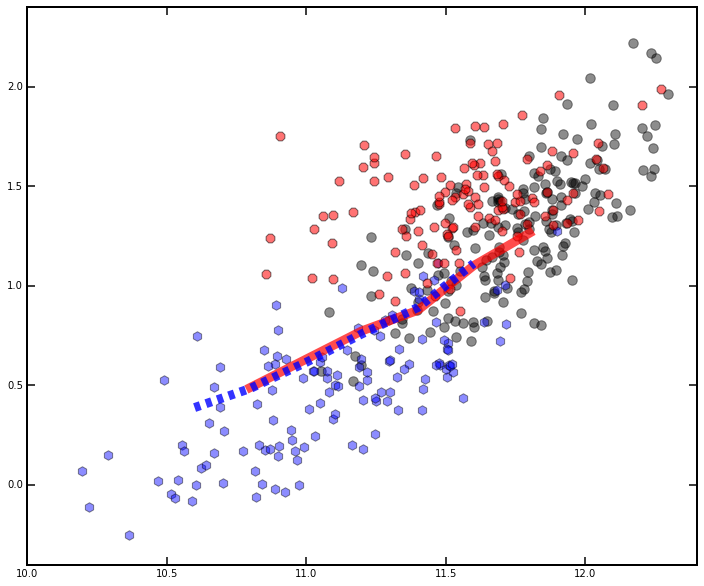

In [30]:
plt.plot(mc, rc, linestyle='-', linewidth=9.0, c='r', alpha=0.7)
plt.plot(ms, rs, linestyle='--', linewidth=9.0, c='b', alpha=0.8)

plt.scatter(logmBcg, logrBcg, c='k', alpha=0.45, s=90)
plt.scatter(logm1Bcg, logr1Bcg, c='b', alpha=0.45, s=90, marker='h')
plt.scatter(logm2Bcg, logr2Bcg, c='r', alpha=0.55, s=90, marker='8')

plt.xlim(10.0, 12.4)
plt.ylim(-0.4, 2.4)

plt.show()

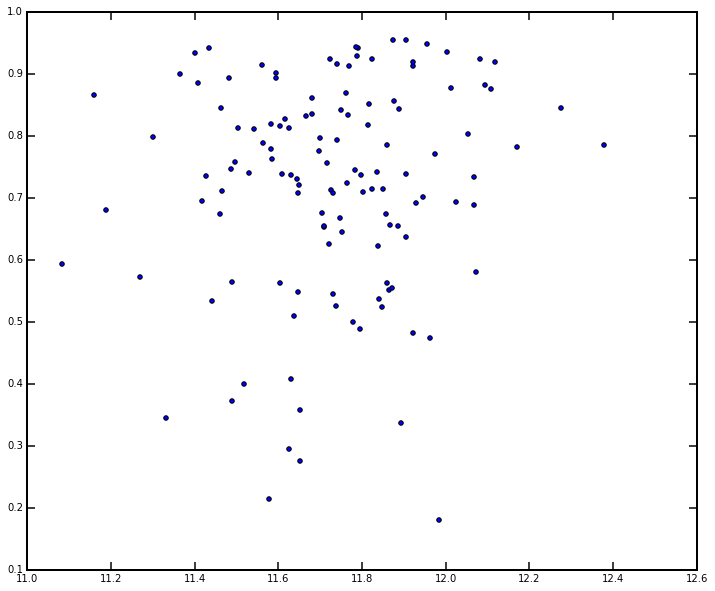

In [94]:
temp1 = 10.0 ** np.asarray(logm1Bcg)
temp2 = 10.0 ** np.asarray(logm2Bcg)
plt.scatter(np.log10(temp1 + temp2), (temp2 / (temp1 + temp2)))
plt.show()

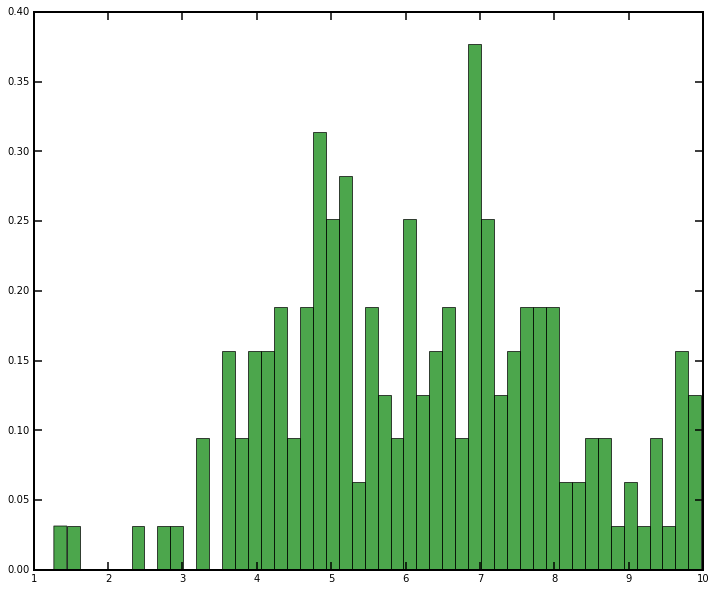

In [95]:
temp = plt.hist(nserBcg, 50, normed=1, facecolor='green', alpha=0.7)
plt.show()

# Members: (The most massive bin has problem !)

In [31]:
logmMem, logrMem, nserMem = [], [], []
logm1Mem, logr1Mem, logm2Mem, logr2Mem = [], [], [], []

sample = 'redMem'
sampleDir = memDir

idStr = 'ISEDFIT_ID'
zStr = 'Z'
m2lStr = 'logm2lI_C'
extStr = 'a_i'

for gal in memTab:
    
    galId = str(gal[idStr])
    scale = pixKpc(gal[zStr], show=False)
    logm2l = gal[m2lStr]
    
    ## Ser1 
    ser1File = sample + '_' + galId + '_HSC-I_full_1ser.pkl'
    ser1File = os.path.join(newDir, memDir, ser1File)
    
    if os.path.isfile(ser1File): 
        obj1Ser = loadGalfitOutput(ser1File)
        try: 
            aic1, bic1, hq1 = gSimple.galfitAIC(obj1Ser)
        except Exception:
            print("## Something is wrong with: %s" % ser1File)
            aic1, bic1, hq1 = None, None, None 
        else:
            ser1comp = obj1Ser.component_1
            # log(Re/kpc)
            logr1 = np.log10(ser1comp.re * np.sqrt(ser1comp.ar) * scale)
            # log(M)
            logm1 = getLuminosity(ser1comp.mag, gal[zStr], 
                                  extinction=gal[extStr], amag_sun=amag_sun_des_i) + logm2l
            if (ser1comp.good and ser1comp.n > 0.5 and ser1comp.n < 10.0 and 
                ser1comp.ar >= 0.3 and obj1Ser.reduced_chisq < 5.0 and 
                logr1 <= 2.6):
                
                logmMem.append(logm1)
                logrMem.append(logr1)
                nserMem.append(nserMem)
    else: 
        aic1, bic1, hq1 = None, None, None 
        #print("## Can not find 1 Sersic model for %s" % ser1File)
        
        
    ## Ser2
    ser2File = sample + '_' + galId + '_HSC-I_full_2ser.pkl'
    ser2File = os.path.join(newDir, sampleDir, ser2File)
    
    if os.path.isfile(ser2File): 
        obj2Ser = loadGalfitOutput(ser2File)
        try: 
            aic2, bic2, hq2 = gSimple.galfitAIC(obj2Ser)
        except Exception:
            aic2, bic2, hq2 = None, None, None 
            print("## Something is wrong with: %s" % ser2File)
        else:
            ser2comp1 = obj2Ser.component_1
            ser2comp2 = obj2Ser.component_2
            
            if ser2comp1.re > ser2comp2.re: 
                ser2comp1, ser2comp2 = ser2comp2, ser2comp1
            
            flux1 = 10.0 ** ((27.0 - ser2comp1.mag) / 2.5)
            flux2 = 10.0 ** ((27.0 - ser2comp2.mag) / 2.5)
            frac1 = flux1 / (flux1 + flux2)
            
            mu1 = (flux1 / (ser2comp1.ar * (ser2comp1.re ** 2.0 )))
            mu2 = (flux2 / (ser2comp2.ar * (ser2comp2.re ** 2.0 )))
            
            # log(Re/kpc)
            logr2a = np.log10(ser2comp1.re * np.sqrt(ser2comp1.ar) * scale)
            logr2b = np.log10(ser2comp2.re * np.sqrt(ser2comp2.ar) * scale)

            # log(M)
            logm2a = getLuminosity(ser2comp1.mag, gal[zStr], 
                                   extinction=gal[extStr], amag_sun=amag_sun_des_i) + logm2l
            logm2b = getLuminosity(ser2comp2.mag, gal[zStr], 
                                   extinction=gal[extStr], amag_sun=amag_sun_des_i) + logm2l
            
            if (ser2comp1.good and ser2comp1.n > 0.5 and ser2comp1.n < 4.5 and 
                ser2comp1.ar >= 0.25 and obj2Ser.reduced_chisq < 2.0 and 
                logr2a <= 2.0 and logr2a >= -1.0 and
                ser2comp2.good and ser2comp2.n > 0.5 and ser2comp1.n < 4.5 and 
                ser2comp2.ar >= 0.25 and obj2Ser.reduced_chisq < 2.0 and 
                logr2b <= 2.5 and logr2b >= 0.0 and mu1 >= mu2):
                
                logm1Mem.append(logm2a)
                logm2Mem.append(logm2b)
                logr1Mem.append(logr2a)
                logr2Mem.append(logr2b)
    else: 
        aic2, bic2, hq2 = None, None, None 
        #print("## Can not find 1 Sersic model for %s" % ser2File)
        
        
print(len(logmMem))
print(len(logm1Mem))

1420
586


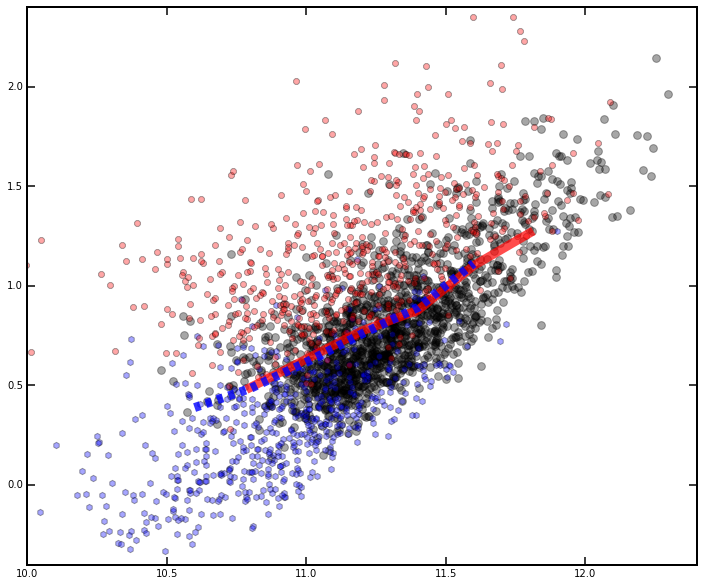

In [32]:
plt.xlim(10.0, 12.4)
plt.ylim(-0.4, 2.4)

plt.plot(mc, rc, linestyle='-', linewidth=9.0, c='r', alpha=0.7)
plt.plot(ms, rs, linestyle='--', linewidth=9.0, c='b', alpha=0.8)

plt.scatter(logmMem, logrMem, c='k', alpha=0.35, s=60)
plt.scatter(logm1Mem, logr1Mem, c='b', alpha=0.35, marker='h', s=40)
plt.scatter(logm2Mem, logr2Mem, c='r', alpha=0.35, marker='8', s=40)

plt.show()

# GAMA1 

In [33]:
logmGama1, logrGama1, nserGama1 = [], [], []
logm1Gama1, logr1Gama1, logm2Gama1, logr2Gama1 = [], [], [], []

sample = 'gama'
sampleDir = gama1Dir

idStr = 'ISEDFIT_ID'
zStr = 'Z'
m2lStr = 'logm2lI_C'
extStr = 'a_i'

for gal in gama1Tab:
    
    galId = str(gal[idStr])
    scale = pixKpc(gal[zStr], show=False)
    logm2l = gal[m2lStr]
    
    ## Ser1 
    ser1File = sample + '_' + galId + '_HSC-I_full_1ser.pkl'
    ser1File = os.path.join(newDir, gama1Dir, ser1File)
    
    if os.path.isfile(ser1File): 
        obj1Ser = loadGalfitOutput(ser1File)
        try: 
            aic1, bic1, hq1 = gSimple.galfitAIC(obj1Ser)
        except Exception:
            print("## Something is wrong with: %s" % ser1File)
            aic1, bic1, hq1 = None, None, None 
        else:
            ser1comp = obj1Ser.component_1
            # log(Re/kpc)
            logr1 = np.log10(ser1comp.re * np.sqrt(ser1comp.ar) * scale)
            # log(M)
            logm1 = getLuminosity(ser1comp.mag, gal[zStr], 
                                  extinction=gal[extStr], amag_sun=amag_sun_des_i) + logm2l
            if (ser1comp.good and ser1comp.n > 0.5 and ser1comp.n < 10.0 and 
                ser1comp.ar >= 0.3 and obj1Ser.reduced_chisq < 5.0 and 
                logr1 <= 2.6):
                
                logmGama1.append(logm1)
                logrGama1.append(logr1)
                nserGama1.append(ser1comp.n)
    else: 
        aic1, bic1, hq1 = None, None, None 
        #print("## Can not find 1 Sersic model for %s" % ser1File)
        
        
    ## Ser2
    ser2File = sample + '_' + galId + '_HSC-I_full_2ser.pkl'
    ser2File = os.path.join(newDir, sampleDir, ser2File)
    
    if os.path.isfile(ser2File): 
        obj2Ser = loadGalfitOutput(ser2File)
        try: 
            aic2, bic2, hq2 = gSimple.galfitAIC(obj2Ser)
        except Exception:
            aic2, bic2, hq2 = None, None, None 
            print("## Something is wrong with: %s" % ser2File)
        else:
            ser2comp1 = obj2Ser.component_1
            ser2comp2 = obj2Ser.component_2
            
            if ser2comp1.re > ser2comp2.re: 
                ser2comp1, ser2comp2 = ser2comp2, ser2comp1
            
            flux1 = 10.0 ** ((27.0 - ser2comp1.mag) / 2.5)
            flux2 = 10.0 ** ((27.0 - ser2comp2.mag) / 2.5)
            frac1 = flux1 / (flux1 + flux2)
            
            mu1 = (flux1 / (ser2comp1.ar * (ser2comp1.re ** 2.0 )))
            mu2 = (flux2 / (ser2comp2.ar * (ser2comp2.re ** 2.0 )))
            
            # log(Re/kpc)
            logr2a = np.log10(ser2comp1.re * np.sqrt(ser2comp1.ar) * scale)
            logr2b = np.log10(ser2comp2.re * np.sqrt(ser2comp2.ar) * scale)

            # log(M)
            logm2a = getLuminosity(ser2comp1.mag, gal[zStr], 
                                   extinction=gal[extStr], amag_sun=amag_sun_des_i) + logm2l
            logm2b = getLuminosity(ser2comp2.mag, gal[zStr], 
                                   extinction=gal[extStr], amag_sun=amag_sun_des_i) + logm2l
            
            if (ser2comp1.good and ser2comp1.n > 0.5 and ser2comp1.n < 4.5 and 
                ser2comp1.ar >= 0.25 and obj2Ser.reduced_chisq < 2.0 and 
                logr2a <= 2.0 and logr2a >= -1.0 and
                ser2comp2.good and ser2comp2.n > 0.5 and ser2comp1.n < 4.5 and 
                ser2comp2.ar >= 0.25 and obj2Ser.reduced_chisq < 2.0 and 
                logr2b <= 2.5 and logr2b >= 0.0 and mu1 >= mu2):
                
                logm1Gama1.append(logm2a)
                logm2Gama1.append(logm2b)
                logr1Gama1.append(logr2a)
                logr2Gama1.append(logr2b)
    else: 
        aic2, bic2, hq2 = None, None, None 
        #print("## Can not find 1 Sersic model for %s" % ser2File)
        
        
print(len(logmGama1))
print(len(logm1Gama1))

3400
1564


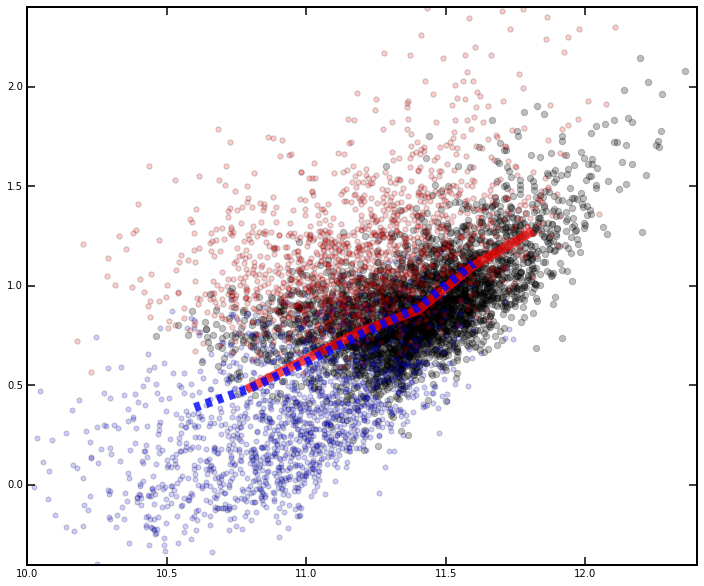

In [34]:
plt.xlim(10.0, 12.4)
plt.ylim(-0.4, 2.4)

plt.plot(mc, rc, linestyle='-', linewidth=9.0, c='r', alpha=0.7)
plt.plot(ms, rs, linestyle='--', linewidth=9.0, c='b', alpha=0.8)

plt.scatter(logmGama1, logrGama1, c='k', alpha=0.25, s=40)
plt.scatter(logm1Gama1, logr1Gama1, c='b', alpha=0.20, marker='h', s=30)
plt.scatter(logm2Gama1, logr2Gama1, c='r', alpha=0.20, marker='8', s=30)

plt.show()

# GAMA2 

In [35]:
logmGama2, logrGama2, nserGama2 = [], [], []
logm1Gama2, logr1Gama2, logm2Gama2, logr2Gama2 = [], [], [], []

sample = 'gama'
sampleDir = gama2Dir

idStr = 'ISEDFIT_ID'
zStr = 'Z'
m2lStr = 'logm2lI_C'
extStr = 'a_i'

for gal in gama2Tab:
    
    galId = str(gal[idStr])
    scale = pixKpc(gal[zStr], show=False)
    logm2l = gal[m2lStr]
    
    ## Ser1 
    ser1File = sample + '_' + galId + '_HSC-I_full_1ser.pkl'
    ser1File = os.path.join(newDir, gama2Dir, ser1File)
    
    if os.path.isfile(ser1File): 
        obj1Ser = loadGalfitOutput(ser1File)
        try: 
            aic1, bic1, hq1 = gSimple.galfitAIC(obj1Ser)
        except Exception:
            print("## Something is wrong with: %s" % ser1File)
            aic1, bic1, hq1 = None, None, None 
        else:
            ser1comp = obj1Ser.component_1
            # log(Re/kpc)
            logr1 = np.log10(ser1comp.re * np.sqrt(ser1comp.ar) * scale)
            # log(M)
            logm1 = getLuminosity(ser1comp.mag, gal[zStr], 
                                  extinction=gal[extStr], amag_sun=amag_sun_des_i) + logm2l
            if (ser1comp.good and ser1comp.n > 0.5 and ser1comp.n < 10.0 and 
                ser1comp.ar >= 0.3 and obj1Ser.reduced_chisq < 5.0 and 
                logr1 <= 2.6):
                
                logmGama2.append(logm1)
                logrGama2.append(logr1)
                nserGama2.append(ser1comp.n)
    else: 
        aic1, bic1, hq1 = None, None, None 
        #print("## Can not find 1 Sersic model for %s" % ser1File)
        
        
    ## Ser2
    ser2File = sample + '_' + galId + '_HSC-I_full_2ser.pkl'
    ser2File = os.path.join(newDir, sampleDir, ser2File)
    
    if os.path.isfile(ser2File): 
        obj2Ser = loadGalfitOutput(ser2File)
        try: 
            aic2, bic2, hq2 = gSimple.galfitAIC(obj2Ser)
        except Exception:
            aic2, bic2, hq2 = None, None, None 
            print("## Something is wrong with: %s" % ser2File)
        else:
            ser2comp1 = obj2Ser.component_1
            ser2comp2 = obj2Ser.component_2
            
            if ser2comp1.re > ser2comp2.re: 
                ser2comp1, ser2comp2 = ser2comp2, ser2comp1
            
            flux1 = 10.0 ** ((27.0 - ser2comp1.mag) / 2.5)
            flux2 = 10.0 ** ((27.0 - ser2comp2.mag) / 2.5)
            frac1 = flux1 / (flux1 + flux2)
            
            mu1 = (flux1 / (ser2comp1.ar * (ser2comp1.re ** 2.0 )))
            mu2 = (flux2 / (ser2comp2.ar * (ser2comp2.re ** 2.0 )))
            
            # log(Re/kpc)
            logr2a = np.log10(ser2comp1.re * np.sqrt(ser2comp1.ar) * scale)
            logr2b = np.log10(ser2comp2.re * np.sqrt(ser2comp2.ar) * scale)

            # log(M)
            logm2a = getLuminosity(ser2comp1.mag, gal[zStr], 
                                   extinction=gal[extStr], amag_sun=amag_sun_des_i) + logm2l
            logm2b = getLuminosity(ser2comp2.mag, gal[zStr], 
                                   extinction=gal[extStr], amag_sun=amag_sun_des_i) + logm2l
            
            if (ser2comp1.good and ser2comp1.n > 0.5 and ser2comp1.n < 4.5 and 
                ser2comp1.ar >= 0.25 and obj2Ser.reduced_chisq < 2.0 and 
                logr2a <= 2.0 and logr2a >= -1.0 and
                ser2comp2.good and ser2comp2.n > 0.5 and ser2comp1.n < 4.5 and 
                ser2comp2.ar >= 0.25 and obj2Ser.reduced_chisq < 2.0 and 
                logr2b <= 2.5 and logr2b >= 0.0 and mu1 >= mu2):
                
                logm1Gama2.append(logm2a)
                logm2Gama2.append(logm2b)
                logr1Gama2.append(logr2a)
                logr2Gama2.append(logr2b)
    else: 
        aic2, bic2, hq2 = None, None, None 
        #print("## Can not find 1 Sersic model for %s" % ser2File)
        
        
print(len(logmGama2))
print(len(logm1Gama2))

1479
785


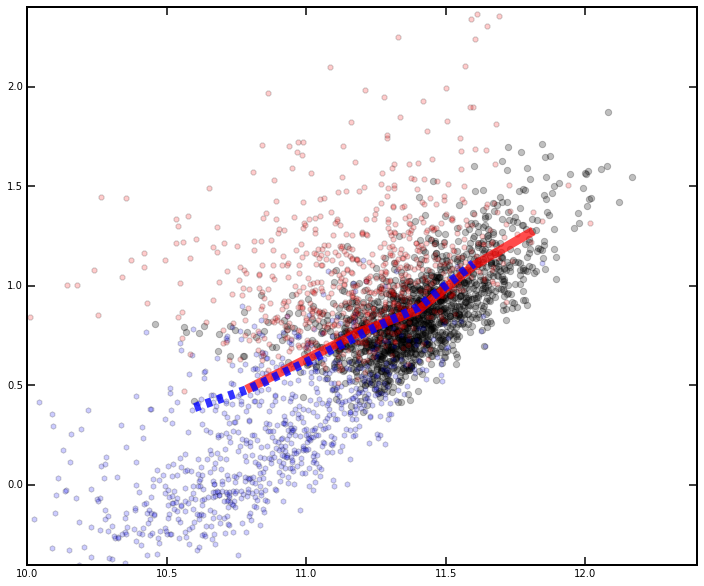

In [36]:
plt.xlim(10.0, 12.4)
plt.ylim(-0.4, 2.4)

plt.plot(mc, rc, linestyle='-', linewidth=9.0, c='r', alpha=0.7)
plt.plot(ms, rs, linestyle='--', linewidth=9.0, c='b', alpha=0.8)

plt.scatter(logmGama2, logrGama2, c='k', alpha=0.25, s=40)
plt.scatter(logm1Gama2, logr1Gama2, c='b', alpha=0.20, marker='h', s=30)
plt.scatter(logm2Gama2, logr2Gama2, c='r', alpha=0.20, marker='8', s=30)

plt.show()

# GAMA3

In [37]:
logmGama3, logrGama3, nserGama3 = [], [], []
logm1Gama3, logr1Gama3, logm2Gama3, logr2Gama3 = [], [], [], []

sample = 'gama'
sampleDir = gama3Dir

idStr = 'ISEDFIT_ID'
zStr = 'Z'
m2lStr = 'logm2lI_C'
extStr = 'a_i'

for gal in gama3Tab:
    
    galId = str(gal[idStr])
    scale = pixKpc(gal[zStr], show=False)
    logm2l = gal[m2lStr]
    
    ## Ser1 
    ser1File = sample + '_' + galId + '_HSC-I_full_1ser.pkl'
    ser1File = os.path.join(newDir, gama3Dir, ser1File)
    
    if os.path.isfile(ser1File): 
        obj1Ser = loadGalfitOutput(ser1File)
        try: 
            aic1, bic1, hq1 = gSimple.galfitAIC(obj1Ser)
        except Exception:
            print("## Something is wrong with: %s" % ser1File)
            aic1, bic1, hq1 = None, None, None 
        else:
            ser1comp = obj1Ser.component_1
            # log(Re/kpc)
            logr1 = np.log10(ser1comp.re * np.sqrt(ser1comp.ar) * scale)
            # log(M)
            logm1 = getLuminosity(ser1comp.mag, gal[zStr], 
                                  extinction=gal[extStr], amag_sun=amag_sun_des_i) + logm2l
            if (ser1comp.good and ser1comp.n > 0.5 and ser1comp.n < 10.0 and 
                ser1comp.ar >= 0.3 and obj1Ser.reduced_chisq < 5.0 and 
                logr1 <= 2.6):
                
                logmGama3.append(logm1)
                logrGama3.append(logr1)
                nserGama3.append(ser1comp.n)
    else: 
        aic1, bic1, hq1 = None, None, None 
        #print("## Can not find 1 Sersic model for %s" % ser1File)
        
        
    ## Ser2
    ser2File = sample + '_' + galId + '_HSC-I_full_2ser.pkl'
    ser2File = os.path.join(newDir, sampleDir, ser2File)
    
    if os.path.isfile(ser2File): 
        obj2Ser = loadGalfitOutput(ser2File)
        try: 
            aic2, bic2, hq2 = gSimple.galfitAIC(obj2Ser)
        except Exception:
            aic2, bic2, hq2 = None, None, None 
            print("## Something is wrong with: %s" % ser2File)
        else:
            ser2comp1 = obj2Ser.component_1
            ser2comp2 = obj2Ser.component_2
            
            if ser2comp1.re > ser2comp2.re: 
                ser2comp1, ser2comp2 = ser2comp2, ser2comp1
            
            flux1 = 10.0 ** ((27.0 - ser2comp1.mag) / 2.5)
            flux2 = 10.0 ** ((27.0 - ser2comp2.mag) / 2.5)
            frac1 = flux1 / (flux1 + flux2)
            
            mu1 = (flux1 / (ser2comp1.ar * (ser2comp1.re ** 2.0 )))
            mu2 = (flux2 / (ser2comp2.ar * (ser2comp2.re ** 2.0 )))
            
            # log(Re/kpc)
            logr2a = np.log10(ser2comp1.re * np.sqrt(ser2comp1.ar) * scale)
            logr2b = np.log10(ser2comp2.re * np.sqrt(ser2comp2.ar) * scale)

            # log(M)
            logm2a = getLuminosity(ser2comp1.mag, gal[zStr], 
                                   extinction=gal[extStr], amag_sun=amag_sun_des_i) + logm2l
            logm2b = getLuminosity(ser2comp2.mag, gal[zStr], 
                                   extinction=gal[extStr], amag_sun=amag_sun_des_i) + logm2l
            
            if (ser2comp1.good and ser2comp1.n > 0.5 and ser2comp1.n < 4.5 and 
                ser2comp1.ar >= 0.25 and obj2Ser.reduced_chisq < 2.0 and 
                logr2a <= 2.0 and logr2a >= -1.0 and
                ser2comp2.good and ser2comp2.n > 0.5 and ser2comp1.n < 4.5 and 
                ser2comp2.ar >= 0.25 and obj2Ser.reduced_chisq < 2.0 and 
                logr2b <= 2.5 and logr2b >= 0.0 and mu1 >= mu2):
                
                logm1Gama3.append(logm2a)
                logm2Gama3.append(logm2b)
                logr1Gama3.append(logr2a)
                logr2Gama3.append(logr2b)
    else: 
        aic2, bic2, hq2 = None, None, None 
        #print("## Can not find 1 Sersic model for %s" % ser2File)
        
        
print(len(logmGama3))
print(len(logm1Gama3))

2337
957


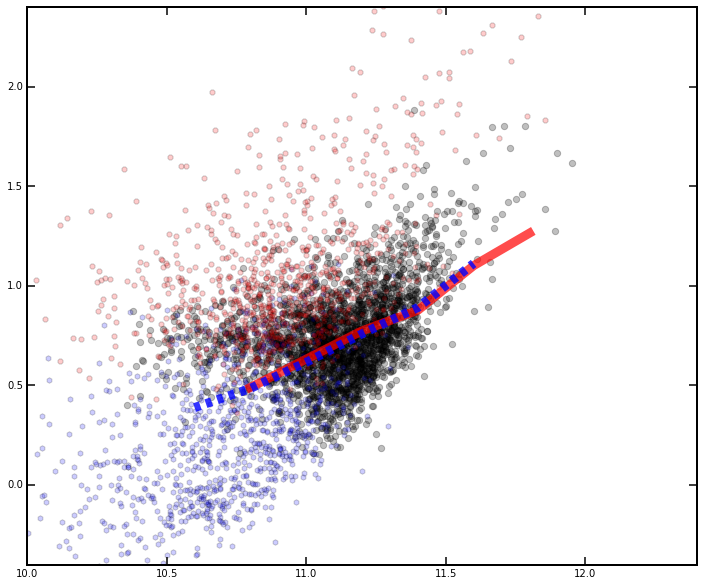

In [38]:
plt.xlim(10.0, 12.4)
plt.ylim(-0.4, 2.4)

plt.plot(mc, rc, linestyle='-', linewidth=9.0, c='r', alpha=0.7)
plt.plot(ms, rs, linestyle='--', linewidth=9.0, c='b', alpha=0.8)

plt.scatter(logmGama3, logrGama3, c='k', alpha=0.25, s=40)
plt.scatter(logm1Gama3, logr1Gama3, c='b', alpha=0.20, marker='h', s=30)
plt.scatter(logm2Gama3, logr2Gama3, c='r', alpha=0.20, marker='8', s=30)

plt.show()

# Summary Plots

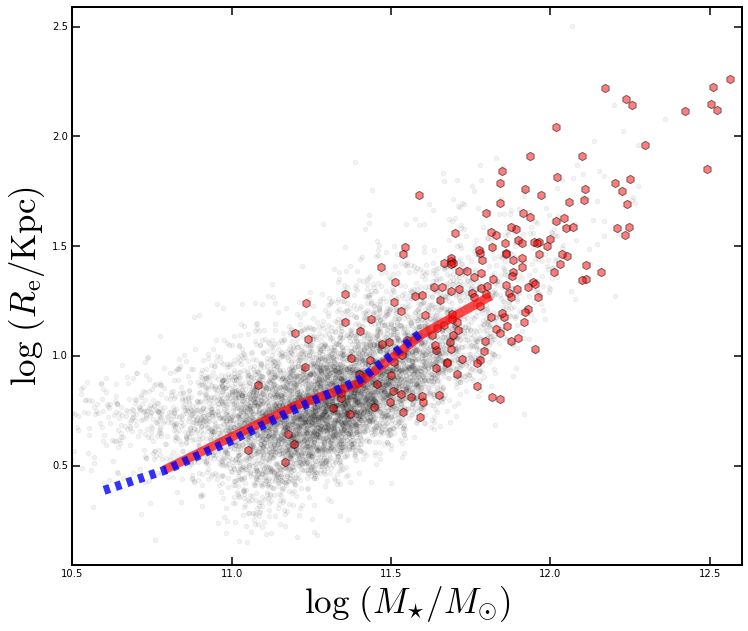

In [39]:
plt.xlim(10.5, 12.6)
plt.ylim(0.05, 2.59)

plt.xlabel('$\log\ (M_{\star}/M_{\odot})$', fontsize=35)
plt.ylabel('$\log\ (R_{\mathrm{e}}/\mathrm{Kpc})$', fontsize=35)

plt.scatter(logmGama1, logrGama1, c='k', alpha=0.05)
plt.scatter(logmGama2, logrGama2, c='k', alpha=0.05)
plt.scatter(logmGama3, logrGama3, c='k', alpha=0.05)

plt.plot(mc, rc, linestyle='-', linewidth=9.0, c='r', alpha=0.7)
plt.plot(ms, rs, linestyle='--', linewidth=9.0, c='b', alpha=0.8)

#plt.scatter(logmMem, logrMem, c='g', alpha=0.1, s=30, marker='s')

plt.scatter(logmBcg, logrBcg, c='r', alpha=0.5, s=70, marker='h')

plt.show()

In [40]:
logmGama = np.asarray(logmGama1 + logmGama2 + logmGama3).ravel()
logrGama = np.asarray(logrGama1 + logrGama2 + logrGama3).ravel()
nserGama = np.asarray(nserGama1 + nserGama2 + nserGama3).ravel()

In [41]:
logmGamaU = logmGama[logmGama >= 11.42]
logrGamaU = logrGama[logmGama >= 11.42]
nserGamaU = nserGama[logmGama >= 11.42]

In [42]:
logmBcg = np.asarray(logmBcg)
logrBcg = np.asarray(logrBcg)
nserBcg = np.asarray(nserBcg)

logmBcgU = logmBcg[logmBcg >= 11.42]
logrBcgU = logrBcg[logmBcg >= 11.42]
nserBcgU = nserBcg[logmBcg >= 11.42]

In [43]:
logmGamaM = logmGama[logmGama >= 11.65]
logrGamaM = logrGama[logmGama >= 11.65]
nserGamaM = nserGama[logmGama >= 11.65]

logmBcgM = logmBcg[logmBcg >= 11.65]
logrBcgM = logrBcg[logmBcg >= 11.65]
nserBcgM = nserBcg[logmBcg >= 11.65]

In [44]:
print(len(logmBcgM))
print(len(logmGamaM))

128
718


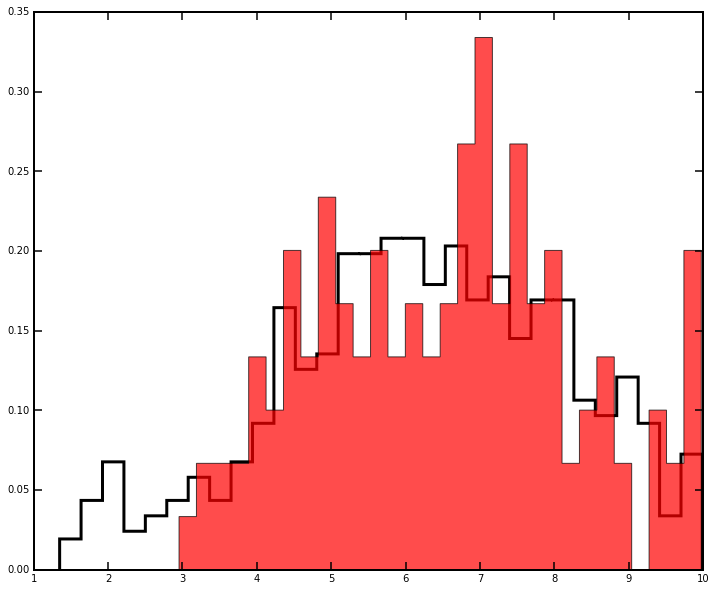

In [45]:
temp = plt.hist(nserGamaM, 30, normed=1, edgecolor='black', 
                alpha=1.0, histtype='step', linewidth=3.0)
temp = plt.hist(nserBcgM, 30, normed=1, facecolor='red', 
                alpha=0.7, histtype='stepfilled')
plt.show()

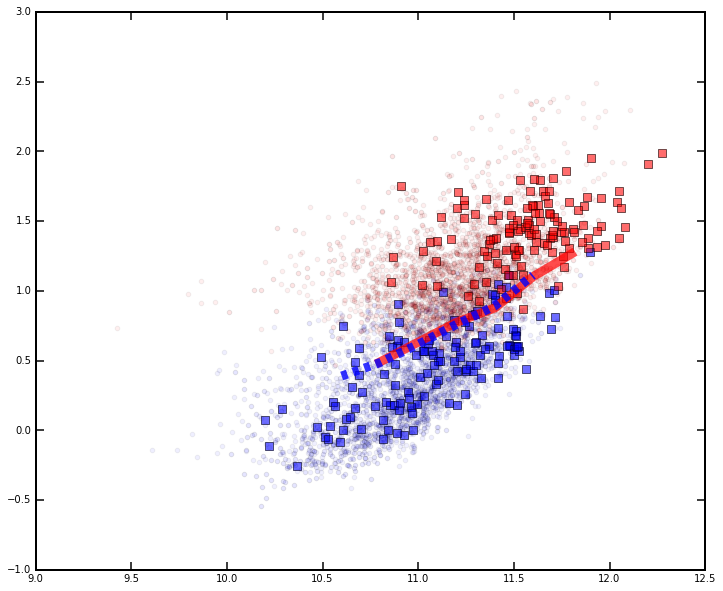

In [47]:
plt.scatter(logm1Gama2, logr1Gama2, c='b', alpha=0.05)
plt.scatter(logm2Gama2, logr2Gama2, c='r', alpha=0.05)

plt.scatter(logm1Gama1, logr1Gama1, c='b', alpha=0.03)
plt.scatter(logm2Gama1, logr2Gama1, c='r', alpha=0.03)

plt.plot(mc, rc, linestyle='-', linewidth=9.0, c='r', alpha=0.7)
plt.plot(ms, rs, linestyle='--', linewidth=9.0, c='b', alpha=0.8)

#plt.scatter(logm1Mem, logr1Mem, facecolor='none', edgecolor='b', alpha=0.2, marker='h', s=60)
#plt.scatter(logm2Mem, logr2Mem, facecolor='none', edgecolor='r', alpha=0.2, marker='h', s=60)

plt.scatter(logm1Bcg, logr1Bcg, c='b', alpha=0.35, s=55, marker='s')
plt.scatter(logm2Bcg, logr2Bcg, c='r', alpha=0.35, s=55, marker='s')

plt.show()

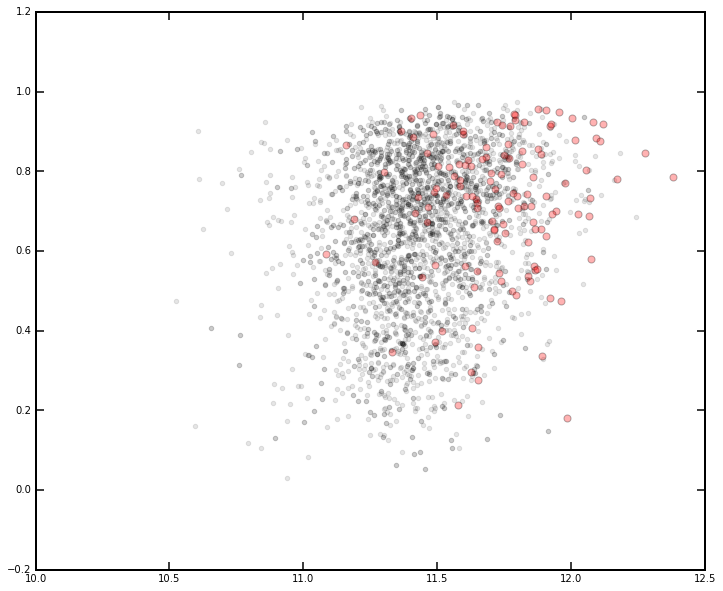

In [48]:
temp1 = 10.0 ** np.asarray(logm1Gama1)
temp2 = 10.0 ** np.asarray(logm2Gama1)
plt.scatter(np.log10(temp1 + temp2), (temp2 / (temp1 + temp2)), alpha=0.1, c='k')

temp1 = 10.0 ** np.asarray(logm1Gama2)
temp2 = 10.0 ** np.asarray(logm2Gama2)
plt.scatter(np.log10(temp1 + temp2), (temp2 / (temp1 + temp2)), alpha=0.2, c='k')

temp1 = 10.0 ** np.asarray(logm1Bcg)
temp2 = 10.0 ** np.asarray(logm2Bcg)
plt.scatter(np.log10(temp1 + temp2), (temp2 / (temp1 + temp2)), c='r', alpha=0.3, s=50)

plt.show()

# Fit Mass-Size Relation

In [133]:
import emcee
import corner

# Likelihood function
def lnlike(theta, x, y, yerr):
    a, b, lnf = theta
    # Straightline model 
    model = a * x + b
    inv_sigma2 = (1.0 / (yerr**2 + model**2*np.exp(2*lnf)))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - 
                         np.log(inv_sigma2)))

# Priors
def lnprior(theta):
    a, b, lnf = theta
    if 0.6 < a < 1.3 and -13.0 < b < -7.0 and -4.0 < lnf < 1.0:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

#Llinear least squares solution 
def llsLine(x, y, yerr):
    """ Simple straingt line fitting """
    A = np.vstack((np.ones_like(x), x)).T
    C = np.diag(yerr * yerr)
    cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
    b_ls, a_ls = np.dot(cov, np.dot(A.T, 
                                    np.linalg.solve(C, y)))
    print("LLS: a =%8.5f ; b =%8.5f" % (a_ls, b_ls))
    return a_ls, b_ls
    
# Use Emcee to fit a straight line 
def emceeLine(x, y, yerr, nwalkers=100, ndim=3, nburn=100, 
              nstep=600, show=True): 
    """ Initial guesses from simple LLS fitting """
    a_ls, b_ls = llsLine(x, y, yerr)
    initial = [a_ls, b_ls, 0.00]
    """ Start the sampler """
    sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                    lnprob, args=(x, y, yerr))
    """ Initializing the walkers. """
    np.random.seed(0)
    guesses = [initial + (1e-2*np.random.randn(ndim)) 
               for i in range(nwalkers)]
    """ Run MCMC """
    print("Start the MCMC runs")
    %time sampler.run_mcmc(guesses, nstep)
    print("Done")
    """ Flatten the chain so that we have a flat list of samples """
    samples = sampler.chain[:, nburn:, :].reshape(-1, ndim)
    if show:   
        fig = corner.corner(samples, 
                            labels=["$a$", "$b$", "$\ln\,f$"])
    """ Compute the quantiles. """
    samples[:, 2] = np.exp(samples[:, 2])
    a_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                 zip(*np.percentile(samples, [16, 50, 84],
                                                    axis=0)))
    print("""MCMC result:
             a = {0[0]} +{0[1]} -{0[2]}
             b = {1[0]} +{1[1]} -{1[2]} 
             f = {2[0]} +{2[1]} -{2[2]}
            """.format(a_mcmc, b_mcmc, f_mcmc))

    return a_mcmc, b_mcmc, f_mcmc

LLS: a = 1.06030 ; b =-11.19350
Start the MCMC runs
CPU times: user 32.4 s, sys: 221 ms, total: 32.6 s
Wall time: 33 s
Done
MCMC result:
             a = 0.960387107648 +0.0755428582291 -0.0750014260391
             b = -10.0134319999 +0.883141848718 -0.889418975333 
             f = 0.168797744636 +0.0104793857322 -0.00963780589871
            


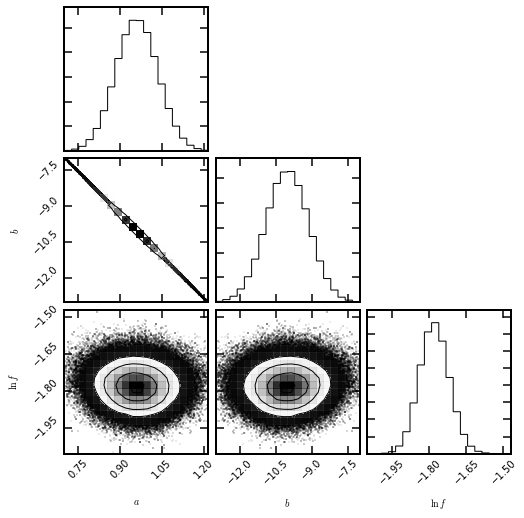

In [138]:
logrBcgErr = logrBcgU * 0.0 + 0.1

a_mcmc, b_mcmc, f_mcmc = emceeLine(logmBcgU, logrBcgU, logrBcgErr, 
                                   nwalkers=200, ndim=3, nburn=1000, 
                                   nstep=5000, show=True)

# Best paramters
aBcgB, aBcgU, aBcgL = a_mcmc
bBcgB, bBcgU, bBcgL = b_mcmc

plt.show()

LLS: a = 1.11484 ; b =-11.84726
Start the MCMC runs
CPU times: user 30.4 s, sys: 213 ms, total: 30.6 s
Wall time: 30.9 s
Done
MCMC result:
             a = 1.05346817881 +0.087570341057 -0.0960961564579
             b = -11.1167335768 +1.14203638725 -1.04036360804 
             f = 0.136025995152 +0.0116197918258 -0.0105804118784
            


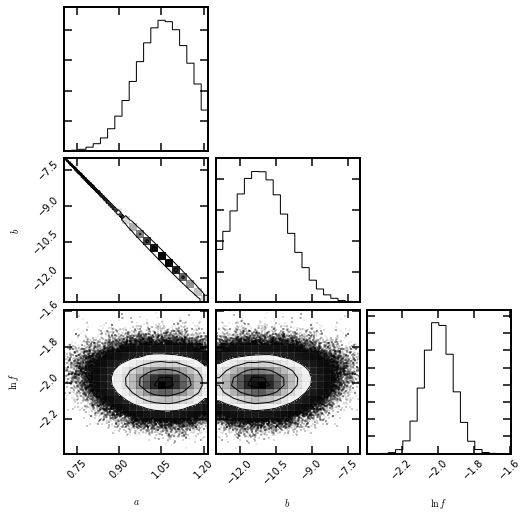

In [145]:
logrBcgErr = logrBcgM * 0.0 + 0.1

a_mcmc, b_mcmc, f_mcmc = emceeLine(logmBcgM, logrBcgM, logrBcgErr, 
                                   nwalkers=200, ndim=3, nburn=1000, 
                                   nstep=5000, show=True)

# Best paramters
aBcgMB, aBcgMU, aBcgML = a_mcmc
bBcgMB, bBcgMU, bBcgML = b_mcmc

plt.show()

LLS: a = 0.98311 ; b =-10.36786
Start the MCMC runs
CPU times: user 1min 18s, sys: 526 ms, total: 1min 19s
Wall time: 1min 20s
Done
MCMC result:
             a = 0.935475557486 +0.026570857285 -0.026374388974
             b = -9.81576469101 +0.305357355175 -0.307325596592 
             f = 0.15056796201 +0.00316298933649 -0.00311714344817
            


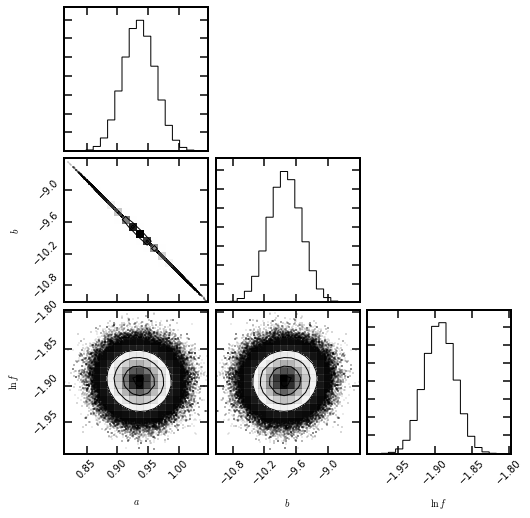

In [146]:
logrGamaErr = logrGamaU * 0.0 + 0.1

a_mcmc, b_mcmc, f_mcmc = emceeLine(logmGamaU, logrGamaU, logrGamaErr, 
                                   nwalkers=200, ndim=3, nburn=1000, 
                                   nstep=5000, show=True)

# Best paramters
aGamaB, aGamaU, aGamaL = a_mcmc
bGamaB, bGamaU, bGamaL = b_mcmc

plt.show()

LLS: a = 1.14132 ; b =-12.23162
Start the MCMC runs
CPU times: user 44.9 s, sys: 342 ms, total: 45.3 s
Wall time: 45.8 s
Done
MCMC result:
             a = 1.07917094165 +0.0611874720565 -0.063355229356
             b = -11.4994194506 +0.746203988875 -0.719735272919 
             f = 0.145059195133 +0.0052755198794 -0.00508546484591
            


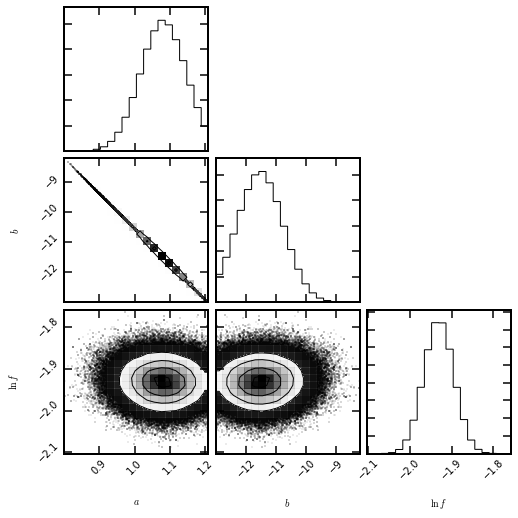

In [147]:
logrGamaErr = logrGamaM * 0.0 + 0.1

a_mcmc, b_mcmc, f_mcmc = emceeLine(logmGamaM, logrGamaM, logrGamaErr, 
                                   nwalkers=200, ndim=3, nburn=1000, 
                                   nstep=5000, show=True)

# Best paramters
aGamaMB, aGamaMU, aGamaML = a_mcmc
bGamaMB, bGamaMU, bGamaML = b_mcmc

plt.show()

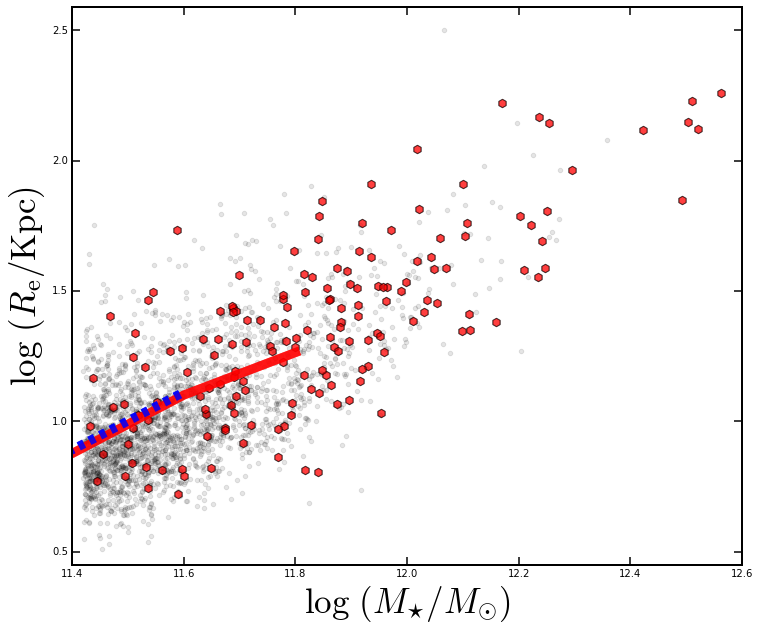

In [50]:
plt.xlim(11.4, 12.6)
plt.ylim(0.45, 2.59)

plt.xlabel('$\log\ (M_{\star}/M_{\odot})$', fontsize=35)
plt.ylabel('$\log\ (R_{\mathrm{e}}/\mathrm{Kpc})$', fontsize=35)

plt.scatter(logmGamaU, logrGamaU, c='k', alpha=0.05)

plt.scatter(logmBcgU, logrBcgU, c='r', alpha=0.5, s=70, marker='h')

plt.plot(mc, rc, linestyle='-', linewidth=9.0, c='r', alpha=0.7)
plt.plot(ms, rs, linestyle='--', linewidth=9.0, c='b', alpha=0.8)

# Red-sequence
xx = np.linspace(10.0, 13.0, 100)
plt.plot(xx, (aBcgMB * xx + bBcgMB),
        linestyle='--', color='r', linewidth=3.5)
#yy1 = (aBcgMB + aBcgMU) * xx + (bBcgMB)
#yy2 = (aBcgMB - aBcgML) * xx + (bBcgMB)
#plt.fill_between(xx, yy1, yy2, 
#                facecolor='r', interpolate=True, alpha=0.15)

xx = np.linspace(10.0, 13.0, 100)
plt.plot(xx, (aGamaMB * xx + bGamaMB),
        linestyle='-.', color='k', linewidth=3.5)
#yy1 = (aGamaMB + aGamaMU) * xx + (bGamaMB)
#yy2 = (aGamaMB - aGamaML) * xx + (bGamaMB)
#plt.fill_between(xx, yy1, yy2, 
#                facecolor='k', interpolate=True, alpha=0.15)

plt.show()

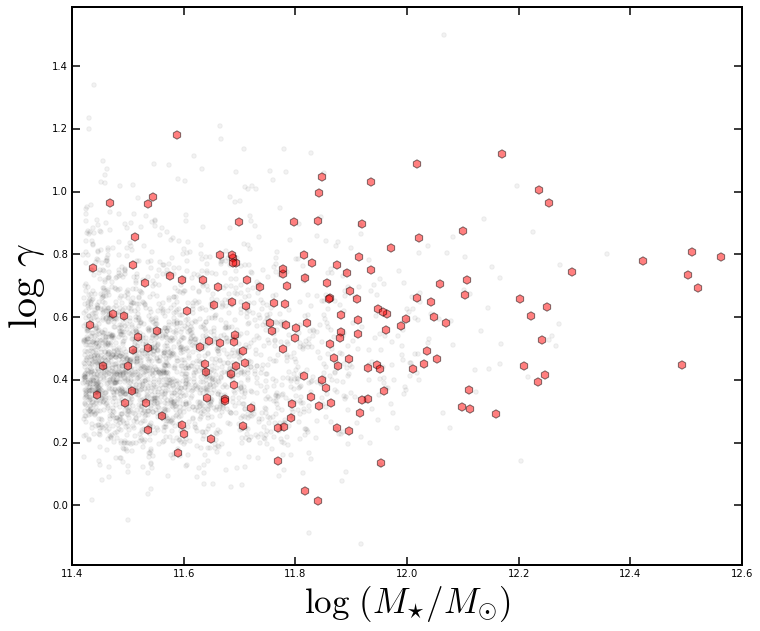

In [170]:
plt.xlim(11.4, 12.6)
plt.ylim(-0.19, 1.59)

plt.xlabel('$\log\ (M_{\star}/M_{\odot})$', fontsize=35)
plt.ylabel('$\log\ \gamma $', fontsize=40)

plt.scatter(logmGamaU, (logrGamaU + 0.94 * (11.0 - logmGamaU)), 
            c='k', alpha=0.05)

plt.scatter(logmBcgU, (logrBcgU + 0.94 * (11.0 - logmBcgU)), 
            c='r', alpha=0.5, s=70, marker='h')

plt.show()

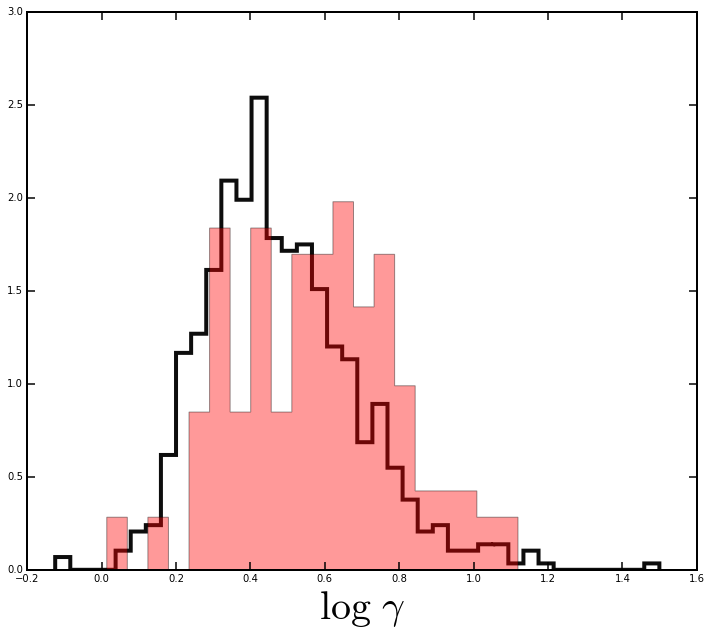

In [173]:
plt.xlabel('$\log\ \gamma $', fontsize=40)

plt.hist((logrGamaM + 0.94 * (11.0 - logmGamaM)), 40, normed=True,
         edgecolor='k', alpha=0.95, histtype='step', linewidth=4.0)

plt.hist((logrBcgM + 0.94 * (11.0 - logmBcgM)), 20, normed=True, 
         facecolor='r', alpha=0.4, histtype='stepfilled')

plt.show()